# WB89_380
Trey V. Wenger - March 2025

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("arviz version:", az.__version__)

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

arviz version: 0.22.0dev
pymc version: 5.21.1
bayes_spec version: 1.7.4
bayes_cn_hfs version: 1.1.1+6.g94944ab.dirty


## Load the data

rms 12CN 0.005452432119031414
rms 13CN 0.0029468342287699194


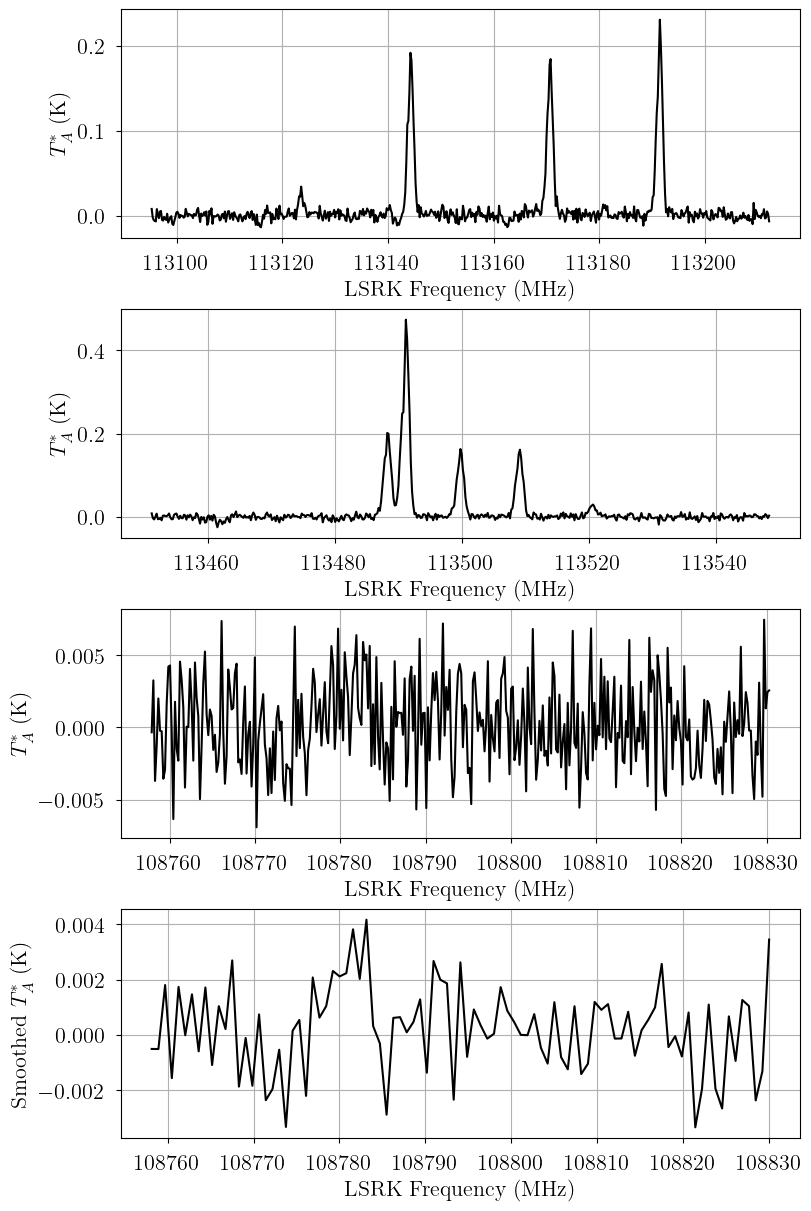

In [3]:
from bayes_spec import SpecData

data_12CN = np.genfromtxt("12CN_WB89_380_freq.dat")
data_13CN = np.genfromtxt("13CN_WB89_380_freq.dat")

# estimate noise
noise_12CN = 1.4826 * np.median(np.abs(data_12CN[:, 1] - np.median(data_12CN[:, 1])))
print("rms 12CN", noise_12CN)
noise_13CN = 1.4826 * np.median(np.abs(data_13CN[:, 1] - np.median(data_13CN[:, 1])))
print("rms 13CN", noise_13CN)

# boxcar smooth 13CN to 4 channels
data_13CN_smo_x = data_13CN[:, 0].reshape(93, 4).mean(axis=1)
data_13CN_smo = data_13CN[:, 1].reshape(93, 4).mean(axis=1)

obs_12CN_1 = SpecData(
    data_12CN[0:600, 0],
    data_12CN[0:600, 1],
    noise_12CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_A^*$ (K)",
)
obs_12CN_2 = SpecData(
    data_12CN[-500:-1, 0],
    data_12CN[-500:-1, 1],
    noise_12CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_A^*$ (K)",
)
obs_13CN_1 = SpecData(
    data_13CN[:, 0],
    data_13CN[:, 1],
    noise_13CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_A^*$ (K)",
)
obs_13CN_2 = SpecData(
    data_13CN_smo_x,
    data_13CN_smo,
    noise_13CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"Smoothed $T_A^*$ (K)",
)
data = {"12CN-1": obs_12CN_1, "12CN-2": obs_12CN_2, "13CN-1": obs_13CN_1, "13CN-2": obs_13CN_2}

# subset of 12CN data
data_12CN = {
    label: data[label]
    for label in data.keys() if "12CN" in label
}

# Plot the data
fig, axes = plt.subplots(len(data), layout="constrained", figsize=(8, 12))
for i, label in enumerate(data.keys()):
    axes[i].plot(data[label].spectral, data[label].brightness, 'k-')
    axes[i].set_xlabel(data[label].xlabel)
    axes[i].set_ylabel(data[label].ylabel)

## Reproduce Sun et al. (2024) model

In [4]:
import astropy.units as u
import astropy.constants as c
from bayes_cn_hfs.utils import supplement_mol_data
from bayes_cn_hfs.physics import calc_stat_weight

mol_data_12CN, weight_12CN = supplement_mol_data("CN")

sun2024_tau_ml = 0.58
sun2024_Tex = 4.34*u.K
freq = 113.5*u.GHz

# main line upper state column density
sun2024_Nu_ml = 8.0*np.pi*freq**2.0 / c.c**2.0 / (np.exp(c.h*freq/(c.k_B*sun2024_Tex)) - 1.0) / (mol_data_12CN["Aul"][5]/u.s) / (1.0/u.MHz) * sun2024_tau_ml
print("main line log10 upper column density", np.log10(sun2024_Nu_ml.to('cm-2').value))

# partition function
stat_weights = calc_stat_weight(mol_data_12CN["states"]["deg"], mol_data_12CN["states"]["E"], sun2024_Tex.to("K").value).eval()
Qtot = np.sum(stat_weights)

# total column density
sun2024_log10_Ntot = np.log10(Qtot/stat_weights[6] * sun2024_Nu_ml.to('cm-2').value)
print("log10 total column density", sun2024_log10_Ntot)

main line log10 upper column density 12.849858056215492
log10 total column density 13.663493893907637


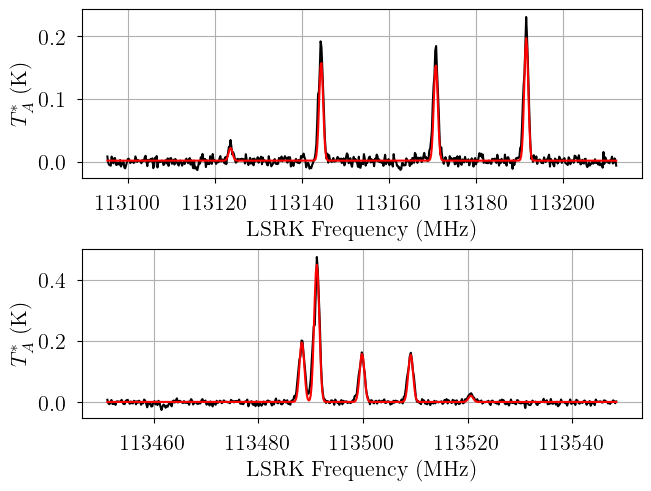

In [5]:
from bayes_cn_hfs.cn_model import CNModel

# Initialize and define the model
baseline_degree = 0
n_clouds = 1
model = CNModel(
    data_12CN,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [13.5, 0.25], # mean and width of log10 total column density prior (cm-2)
    prior_log10_Tkin = [0.75, 0.25], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = {label: 0.03 for label in data_12CN.keys()}, # width of spectral rms prior (K)
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume LTE
    prior_log10_Tex = [0.75, 0.25], # ignored because LTE
    assume_CTEX = True, # implied because LTE
    prior_LTE_precision = 100.0, # ignored because LTE
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

# Simulate with Sun et al. (2024) parameters
# We choose values for velocity and FWHM that look good
sim_params = {
    "log10_N": [sun2024_log10_Ntot],
    "log10_Tkin": [np.log10(sun2024_Tex.to("K").value)],
    "fwhm_nonthermal": [2.75],
    "velocity": [-0.5],
    "fwhm_L": 0.0,
    "rms_12CN-1": 0.0,
    "rms_12CN-2": 0.0,
    "baseline_12CN-1_norm": [0.0],
    "baseline_12CN-2_norm": [0.0],
}

# add derived quantities to sim_params
for key in model.cloud_deterministics:
    if key not in sim_params.keys():
        sim_params[key] = model.model[key].eval(sim_params, on_unused_input="ignore")

# Evaluate and save simulated observations
sim_obs = {label: model.model[label].eval(sim_params, on_unused_input="ignore") for label in data_12CN.keys()}

# Plot the simulated data
fig, axes = plt.subplots(len(data_12CN), layout="constrained")
for i, label in enumerate(data_12CN.keys()):
    axes[i].plot(data_12CN[label].spectral, data_12CN[label].brightness, 'k-')
    axes[i].plot(data_12CN[label].spectral, sim_obs[label], 'r-')
    axes[i].set_xlabel(data_12CN[label].xlabel)
    axes[i].set_ylabel(data_12CN[label].ylabel)

In [6]:
sim_params

{'log10_N': [np.float64(13.663493893907637)],
 'log10_Tkin': [np.float64(0.6374897295125107)],
 'fwhm_nonthermal': [2.75],
 'velocity': [-0.5],
 'fwhm_L': 0.0,
 'rms_12CN-1': 0.0,
 'rms_12CN-2': 0.0,
 'baseline_12CN-1_norm': [0.0],
 'baseline_12CN-2_norm': [0.0],
 'fwhm_thermal': array([0.08740951]),
 'fwhm': array([2.75138882]),
 'log10_Tex_ul': array([0.63748973]),
 'Tex': array([[4.34],
        [4.34],
        [4.34],
        [4.34],
        [4.34],
        [4.34],
        [4.34],
        [4.34],
        [4.34]]),
 'tau': array([[0.02095209],
        [0.17150941],
        [0.16750926],
        [0.21752014],
        [0.21834459],
        [0.58001127],
        [0.17227444],
        [0.16830736],
        [0.02105628]]),
 'tau_total': array([1.73748484]),
 'TR': array([[2.17718756],
        [2.17688599],
        [2.17650447],
        [2.17620343],
        [2.17190905],
        [2.17186795],
        [2.17174278],
        [2.17160848],
        [2.17144243]])}

This simulation is consistent with the Sun et al. (2024) model, but it is not a great fit to the data.

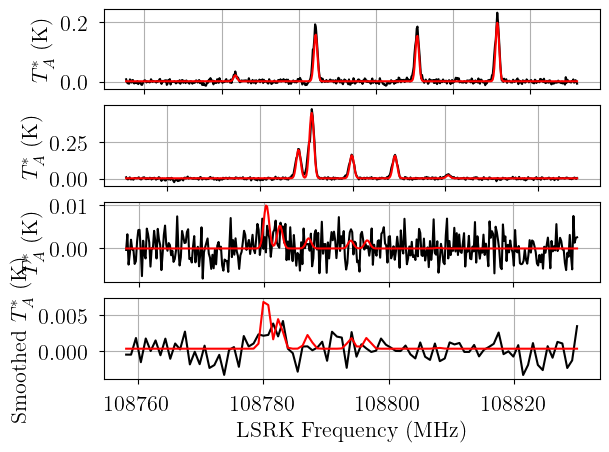

In [7]:
from bayes_cn_hfs import CNRatioModel

sun2024_ratio_12C_13C = 57.0

baseline_degree = 0
n_clouds = 1
model = CNRatioModel(
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [13.8, 0.2], # mean and width of log10 12CN total column density prior (cm-2)
    prior_ratio_12C_13C = [50.0, 25.0], # mean and width of 12C/13C ratio prior
    prior_log10_Tkin = [0.75, 0.25], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = {label: 0.03 for label in data.keys()}, # width of spectral rms prior (K)
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume LTE
    prior_log10_Tex = None, # ignored for this LTE model
    assume_CTEX_12CN = True, # implied for this LTE model
    prior_LTE_precision = 100.0, # ignored for this LTE model
    assume_CTEX_13CN = True, # implied for this LTE model
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

# Simulate with Sun et al. (2024) parameters
# We choose values for velocity and FWHM that look good
sim_params = {
    "log10_N_12CN": [sun2024_log10_Ntot],
    "log10_Tkin": [np.log10(sun2024_Tex.to("K").value)],
    "fwhm_nonthermal": [2.75],
    "velocity": [-0.5],
    "fwhm_L": 0.0,
    "rms_12CN-1": 0.0,
    "rms_12CN-2": 0.0,
    "rms_13CN-1": 0.0,
    "rms_13CN-2": 0.0,
    "baseline_12CN-1_norm": [0.0],
    "baseline_12CN-2_norm": [0.0],
    "baseline_13CN-1_norm": [0.0],
    "baseline_13CN-2_norm": [0.0],
}

# add derived quantities to sim_params
for key in model.cloud_deterministics:
    if key not in sim_params.keys():
        sim_params[key] = model.model[key].eval(sim_params, on_unused_input="ignore")

# Evaluate and save simulated observations
sim_obs = {key: model.model[key].eval(sim_params, on_unused_input="ignore") for key in data.keys()}

# Plot the simulated data
fig, axes = plt.subplots(len(data.keys()))
for ax, key in zip(axes, data.keys()):
    ax.plot(data[key].spectral, data[key].brightness, "k-")
    ax.plot(data[key].spectral, sim_obs[key], "r-")
    ax.set_xlabel(data[key].xlabel)
    ax.set_ylabel(data[key].ylabel)

In [8]:
sim_params

{'log10_N_12CN': [np.float64(13.663493893907637)],
 'log10_Tkin': [np.float64(0.6374897295125107)],
 'fwhm_nonthermal': [2.75],
 'velocity': [-0.5],
 'fwhm_L': 0.0,
 'rms_12CN-1': 0.0,
 'rms_12CN-2': 0.0,
 'rms_13CN-1': 0.0,
 'rms_13CN-2': 0.0,
 'baseline_12CN-1_norm': [0.0],
 'baseline_12CN-2_norm': [0.0],
 'baseline_13CN-1_norm': [0.0],
 'baseline_13CN-2_norm': [0.0],
 'fwhm_thermal_12CN': array([0.08740951]),
 'fwhm_thermal_13CN': array([0.08577554]),
 'fwhm_12CN': array([2.75138882]),
 'fwhm_13CN': array([2.75133739]),
 'N_13CN': array([1.4299262e+12]),
 'log10_Tex_ul': array([0.63748973]),
 'Tex_12CN': array([[4.34],
        [4.34],
        [4.34],
        [4.34],
        [4.34],
        [4.34],
        [4.34],
        [4.34],
        [4.34]]),
 'tau_12CN': array([[0.02095209],
        [0.17150941],
        [0.16750926],
        [0.21752014],
        [0.21834459],
        [0.58001127],
        [0.17227444],
        [0.16830736],
        [0.02105628]]),
 'tau_total_12CN': array([1.

## Ratio Model
We fix the kinetic temperature at the Sun et al. (2024) model value and assume LTE.

In [9]:
from bayes_cn_hfs import CNRatioModel

# Initialize and define the model
baseline_degree = 0
n_clouds = 1
model = CNRatioModel(
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [13.8, 0.2], # mean and width of log10 12CN total column density prior (cm-2)
    prior_ratio_12C_13C = [50.0, 25.0], # mean and width of 12C/13C ratio prior
    prior_log10_Tkin = None, # kinetic temperature is fixed
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume LTE
    prior_log10_Tex = None, # ignored for this LTE model
    assume_CTEX_12CN = True, # implied for this LTE model
    prior_LTE_precision = 100.0, # ignored for this LTE model
    assume_CTEX_13CN = True, # implied for this LTE model
    fix_log10_Tkin = np.log10(sun2024_Tex.to("K").value), # fix the kinetic (excitation) temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Sampling: [12CN-1, 12CN-2, 13CN-1, 13CN-2, baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN-1_norm, baseline_13CN-2_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N_12CN_norm, ratio_12C_13C, velocity_norm]


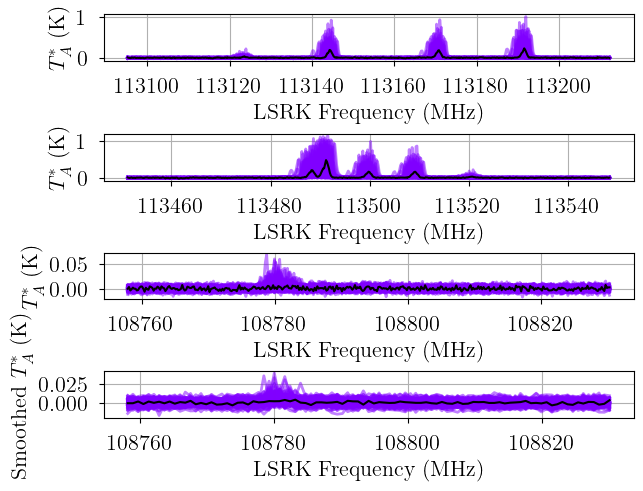

In [10]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [11]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.02, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 2500
Interrupted at 2,499 [2%]: Average Loss = -3,695.8


Output()

Runtime: 0.69 minutes


Sampling: [12CN-1, 12CN-2, 13CN-1, 13CN-2]


Output()

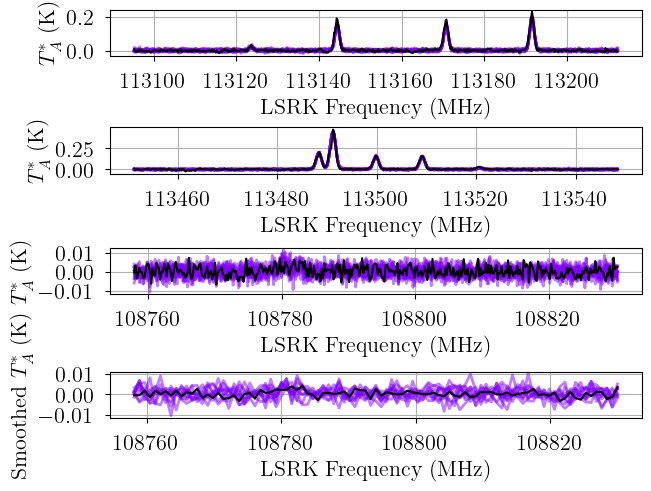

In [12]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [13]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 0.02}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 2500
Interrupted at 2,499 [2%]: Average Loss = -3,695.8
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN-1_norm, baseline_13CN-2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_12CN_norm, ratio_12C_13C]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 44 seconds.


Adding log-likelihood to trace


Output()

Runtime: 1.67 minutes


In [14]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


Sampling: [12CN-1, 12CN-2, 13CN-1, 13CN-2]


Output()

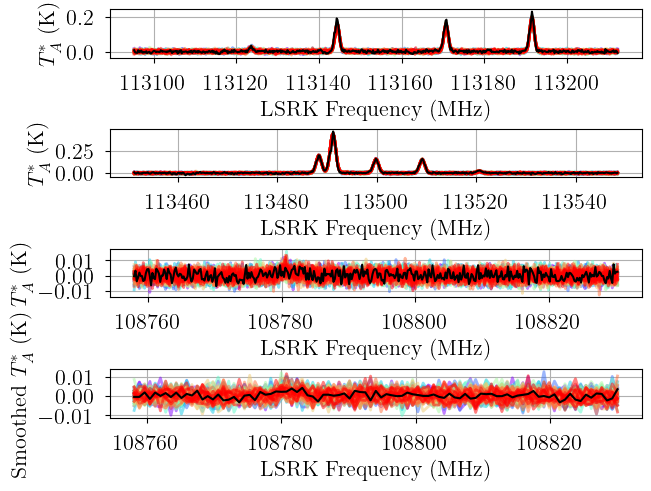

In [15]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [16]:
print("solutions:", model.solutions)

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(
        ["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]
    ))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs + ["ratio_12C_13C"])

solutions: [0]


/home/twenger/miniconda3/envs/bayes_spec-dev/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/twenger/miniconda3/envs/bayes_spec-dev/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/home/twenger/miniconda3/envs/bayes_spec-dev/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean            sd        hdi_3%  \
velocity[0]             -4.750000e-01  9.000000e-03 -4.910000e-01   
fwhm_thermal_12CN[0]     8.700000e-02  0.000000e+00  8.700000e-02   
fwhm_thermal_13CN[0]     8.600000e-02  0.000000e+00  8.600000e-02   
fwhm_nonthermal[0]       3.143000e+00  3.300000e-02  3.080000e+00   
fwhm_12CN[0]             3.144000e+00  3.300000e-02  3.081000e+00   
fwhm_13CN[0]             3.144000e+00  3.300000e-02  3.081000e+00   
log10_N_12CN[0]          1.374400e+01  4.000000e-03  1.373800e+01   
N_13CN[0]                7.788817e+11  1.580728e+11  4.710836e+11   
log10_Tex_ul[0]          6.370000e-01  0.000000e+00  6.370000e-01   
tau_total_12CN[0]        2.094000e+00  1.700000e-02  2.061000e+00   
tau_total_13CN[0]        2.700000e-02  5.000000e-03  1.600000e-02   
fwhm_L                   4.000000e-01  6.900000e-02  2.770000e-01   
baseline_12CN-1_norm[0] -3.600000e-02  4.200000e-02 -1.160000e-01   
baseline_12CN-2_norm[0] -4.050000e-01  5.000000e-02 -4.990000e-01   
baseline_13CN-1_norm[0]  1.500000e-02  5.300000e-02 -8.300000e-02   
baseline_13CN-2_norm[0] -9.200000e-02  1.050000e-01 -2.940000e-01   
ratio_12C_13C[0]         7.444100e+01  1.622800e+01  4.795500e+01   

                              hdi_97%     mcse_mean       mcse_sd  ess_bulk  \
velocity[0]             -4.590000e-01  0.000000e+00  0.000000e+00    7939.0   
fwhm_thermal_12CN[0]     8.700000e-02  0.000000e+00           NaN    8000.0   
fwhm_thermal_13CN[0]     8.600000e-02  0.000000e+00  0.000000e+00    8000.0   
fwhm_nonthermal[0]       3.202000e+00  0.000000e+00  0.000000e+00    4325.0   
fwhm_12CN[0]             3.203000e+00  0.000000e+00  0.000000e+00    4325.0   
fwhm_13CN[0]             3.203000e+00  0.000000e+00  0.000000e+00    4325.0   
log10_N_12CN[0]          1.375100e+01  0.000000e+00  0.000000e+00    3944.0   
N_13CN[0]                1.064156e+12  1.834656e+09  1.669196e+09    7191.0   
log10_Tex_ul[0]          6.370000e-01  0.000000e+00  0.000000e+00    8000.0   
tau_total_12CN[0]        2.126000e+00  0.000000e+00  0.000000e+00    3944.0   
tau_total_13CN[0]        3.700000e-02  0.000000e+00  0.000000e+00    7191.0   
fwhm_L                   5.300000e-01  1.000000e-03  1.000000e-03    3428.0   
baseline_12CN-1_norm[0]  4.000000e-02  0.000000e+00  0.000000e+00    7671.0   
baseline_12CN-2_norm[0] -3.120000e-01  1.000000e-03  1.000000e-03    5846.0   
baseline_13CN-1_norm[0]  1.150000e-01  1.000000e-03  1.000000e-03    8149.0   
baseline_13CN-2_norm[0]  1.020000e-01  1.000000e-03  1.000000e-03    7871.0   
ratio_12C_13C[0]         1.059490e+02  2.060000e-01  2.370000e-01    7170.0   

                         ess_tail  r_hat  
velocity[0]                6098.0    1.0  
fwhm_thermal_12CN[0]       8000.0    NaN  
fwhm_thermal_13CN[0]       8000.0    NaN  
fwhm_nonthermal[0]         5373.0    1.0  
fwhm_12CN[0]               5373.0    1.0  
fwhm_13CN[0]               5373.0    1.0  
log10_N_12CN[0]            5328.0    1.0  
N_13CN[0]                  5309.0    1.0  
log10_Tex_ul[0]            8000.0    NaN  
tau_total_12CN[0]          5328.0    1.0  
tau_total_13CN[0]          5309.0    1.0  
fwhm_L                     4492.0    1.0  
baseline_12CN-1_norm[0]    6355.0    1.0  
baseline_12CN-2_norm[0]    5985.0    1.0  
baseline_13CN-1_norm[0]    6042.0    1.0  
baseline_13CN-2_norm[0]    5735.0    1.0  
ratio_12C_13C[0]           5483.0    1.0

We find a slightly larger $^{12}{\rm C}/^{13}{\rm C}$ ratio: $74 \pm 17$ compared to Sun et al. (2024) who found $57 \pm 17$ using the traditional HfS method and $57 \pm 13$ using the satellite-line method.

## Single component LTE
Mimic Sun et al. (2024) analysis.

In [17]:
# Initialize and define the model
baseline_degree = 0
n_clouds = 1
model = CNModel(
    data_12CN,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [13.75, 0.25], # mean and width of log10 total column density prior (cm-2)
    prior_log10_Tkin = [0.75, 0.25], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume LTE
    prior_log10_Tex = [0.75, 0.25], # ignored because LTE
    assume_CTEX = True, # implied because LTE
    prior_LTE_precision = 100.0, # ignored because LTE
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Sampling: [12CN-1, 12CN-2, baseline_12CN-1_norm, baseline_12CN-2_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N_norm, log10_Tkin_norm, velocity_norm]


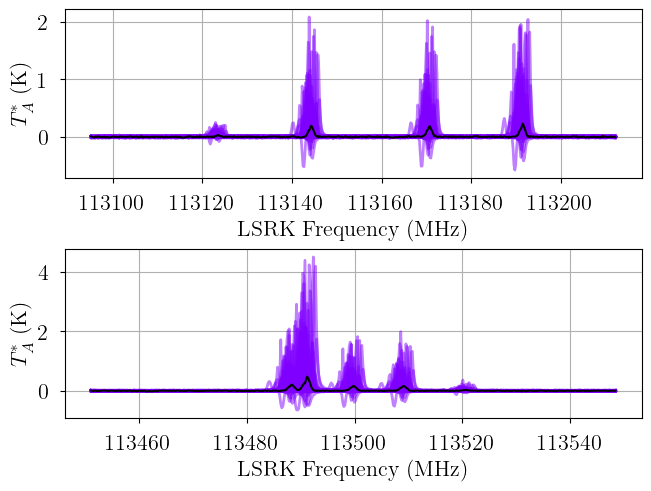

In [18]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [19]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.02, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 2300
Interrupted at 2,299 [2%]: Average Loss = 238.65


Output()

Runtime: 0.36 minutes


Sampling: [12CN-1, 12CN-2]


Output()

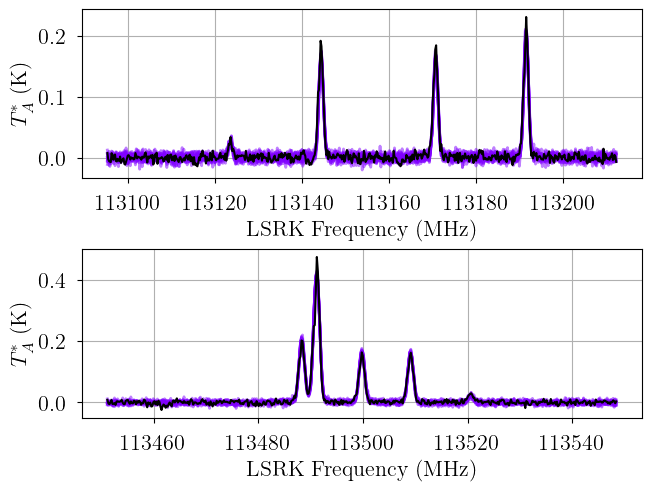

In [20]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [21]:
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
baseline_12CN-1_norm[0]  -0.099  0.043  -0.172   -0.015      0.001    0.001   
baseline_12CN-2_norm[0]  -0.436  0.048  -0.520   -0.341      0.002    0.001   
velocity_norm[0]         -0.152  0.003  -0.158   -0.147      0.000    0.000   
log10_Tkin_norm[0]       -0.720  0.003  -0.726   -0.715      0.000    0.000   
log10_N_norm[0]           0.745  0.012   0.724    0.767      0.000    0.000   
fwhm_nonthermal_norm[0]   3.033  0.021   2.993    3.070      0.001    0.000   
fwhm_L_norm               0.371  0.037   0.306    0.440      0.001    0.001   
velocity[0]              -0.456  0.009  -0.473   -0.440      0.000    0.000   
log10_Tkin[0]             0.570  0.001   0.568    0.571      0.000    0.000   
fwhm_thermal[0]           0.081  0.000   0.081    0.081      0.000    0.000   
fwhm_nonthermal[0]        3.033  0.021   2.993    3.070      0.001    0.000   
fwhm[0]                   3.034  0.021   2.994    3.071      0.001    0.000   
fwhm_L                    0.371  0.037   0.306    0.440      0.001    0.001   
log10_N[0]               13.936  0.003  13.931   13.942      0.000    0.000   
log10_Tex_ul[0]           0.570  0.001   0.568    0.571      0.000    0.000   
Tex[113123.3687, 0]       3.714  0.007   3.702    3.725      0.000    0.000   
Tex[113144.19, 0]         3.714  0.007   3.702    3.725      0.000    0.000   
Tex[113170.535, 0]        3.714  0.007   3.702    3.725      0.000    0.000   
Tex[113191.325, 0]        3.714  0.007   3.702    3.725      0.000    0.000   
Tex[113488.142, 0]        3.714  0.007   3.702    3.725      0.000    0.000   
Tex[113490.985, 0]        3.714  0.007   3.702    3.725      0.000    0.000   
Tex[113499.643, 0]        3.714  0.007   3.702    3.725      0.000    0.000   
Tex[113508.934, 0]        3.714  0.007   3.702    3.725      0.000    0.000   
Tex[113520.4215, 0]       3.714  0.007   3.702    3.725      0.000    0.000   
tau[113123.3687, 0]       0.046  0.000   0.046    0.047      0.000    0.000   
tau[113144.19, 0]         0.379  0.003   0.374    0.385      0.000    0.000   
tau[113170.535, 0]        0.370  0.003   0.366    0.376      0.000    0.000   
tau[113191.325, 0]        0.481  0.003   0.475    0.488      0.000    0.000   
tau[113488.142, 0]        0.483  0.003   0.477    0.489      0.000    0.000   
tau[113490.985, 0]        1.282  0.009   1.266    1.300      0.000    0.000   
tau[113499.643, 0]        0.381  0.003   0.376    0.386      0.000    0.000   
tau[113508.934, 0]        0.372  0.003   0.367    0.377      0.000    0.000   
tau[113520.4215, 0]       0.047  0.000   0.046    0.047      0.000    0.000   
tau_total[0]              3.841  0.028   3.793    3.895      0.001    0.001   
TR[113123.3687, 0]        1.639  0.006   1.628    1.648      0.000    0.000   
TR[113144.19, 0]          1.638  0.006   1.628    1.648      0.000    0.000   
TR[113170.535, 0]         1.638  0.006   1.628    1.647      0.000    0.000   
TR[113191.325, 0]         1.638  0.006   1.627    1.647      0.000    0.000   
TR[113488.142, 0]         1.634  0.006   1.623    1.643      0.000    0.000   
TR[113490.985, 0]         1.634  0.006   1.623    1.643      0.000    0.000   
TR[113499.643, 0]         1.634  0.006   1.623    1.643      0.000    0.000   
TR[113508.934, 0]         1.634  0.006   1.623    1.643      0.000    0.000   
TR[113520.4215, 0]        1.634  0.006   1.623    1.643      0.000    0.000   

                         ess_bulk  ess_tail  r_hat  
baseline_12CN-1_norm[0]     983.0     942.0    NaN  
baseline_12CN-2_norm[0]     936.0     983.0    NaN  
velocity_norm[0]            806.0     905.0    NaN  
log10_Tkin_norm[0]         1049.0     970.0    NaN  
log10_N_norm[0]            1005.0     880.0    NaN  
fwhm_nonthermal_norm[0]     854.0     852.0    NaN  
fwhm_L_norm                 983.0     858.0    NaN  
velocity[0]                 806.0     905.0    NaN  
log10_Tkin[0]              1049.0     970.0    NaN  
fwhm_thermal[0]     

In [22]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 0.02}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.9}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 2300
Interrupted at 2,299 [2%]: Average Loss = 238.65
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, velocity_norm, log10_Tkin_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 55 seconds.


Adding log-likelihood to trace


Output()

Runtime: 1.69 minutes


In [23]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


Sampling: [12CN-1, 12CN-2]


Output()

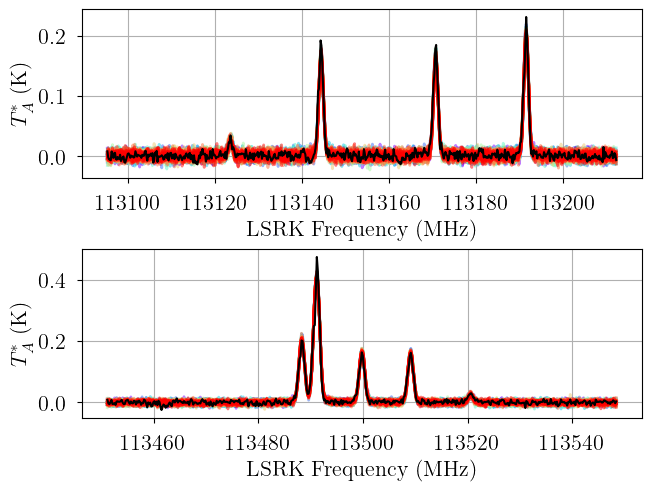

In [24]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [25]:
pm.summary(model.trace.posterior, var_names=model.cloud_deterministics + model.hyper_freeRVs + model.baseline_freeRVs)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
velocity[0]              -0.460  0.009  -0.476   -0.444      0.000    0.000   
log10_Tkin[0]             0.568  0.003   0.562    0.574      0.000    0.000   
fwhm_thermal[0]           0.081  0.000   0.080    0.081      0.000    0.000   
fwhm_nonthermal[0]        3.038  0.032   2.978    3.098      0.000    0.000   
fwhm[0]                   3.039  0.032   2.979    3.099      0.000    0.000   
log10_N[0]               13.945  0.012  13.921   13.967      0.000    0.000   
log10_Tex_ul[0]           0.568  0.003   0.562    0.574      0.000    0.000   
Tex[113123.3687, 0]       3.698  0.026   3.650    3.747      0.000    0.000   
Tex[113144.19, 0]         3.698  0.026   3.650    3.747      0.000    0.000   
Tex[113170.535, 0]        3.698  0.026   3.650    3.747      0.000    0.000   
Tex[113191.325, 0]        3.698  0.026   3.650    3.747      0.000    0.000   
Tex[113488.142, 0]        3.698  0.026   3.650    3.747      0.000    0.000   
Tex[113490.985, 0]        3.698  0.026   3.650    3.747      0.000    0.000   
Tex[113499.643, 0]        3.698  0.026   3.650    3.747      0.000    0.000   
Tex[113508.934, 0]        3.698  0.026   3.650    3.747      0.000    0.000   
Tex[113520.4215, 0]       3.698  0.026   3.650    3.747      0.000    0.000   
tau[113123.3687, 0]       0.047  0.002   0.044    0.050      0.000    0.000   
tau[113144.19, 0]         0.389  0.014   0.362    0.413      0.000    0.000   
tau[113170.535, 0]        0.379  0.013   0.353    0.404      0.000    0.000   
tau[113191.325, 0]        0.493  0.017   0.459    0.524      0.000    0.000   
tau[113488.142, 0]        0.494  0.017   0.461    0.526      0.000    0.000   
tau[113490.985, 0]        1.314  0.046   1.224    1.398      0.001    0.001   
tau[113499.643, 0]        0.390  0.014   0.363    0.415      0.000    0.000   
tau[113508.934, 0]        0.381  0.013   0.355    0.406      0.000    0.000   
tau[113520.4215, 0]       0.048  0.002   0.044    0.051      0.000    0.000   
tau_total[0]              3.935  0.139   3.666    4.187      0.002    0.002   
TR[113123.3687, 0]        1.625  0.022   1.585    1.666      0.000    0.000   
TR[113144.19, 0]          1.625  0.022   1.584    1.666      0.000    0.000   
TR[113170.535, 0]         1.624  0.022   1.584    1.666      0.000    0.000   
TR[113191.325, 0]         1.624  0.022   1.584    1.666      0.000    0.000   
TR[113488.142, 0]         1.620  0.022   1.580    1.662      0.000    0.000   
TR[113490.985, 0]         1.620  0.022   1.580    1.662      0.000    0.000   
TR[113499.643, 0]         1.620  0.022   1.580    1.662      0.000    0.000   
TR[113508.934, 0]         1.620  0.022   1.580    1.661      0.000    0.000   
TR[113520.4215, 0]        1.620  0.022   1.580    1.661      0.000    0.000   
fwhm_L_norm               0.382  0.061   0.263    0.493      0.001    0.001   
baseline_12CN-1_norm[0]  -0.094  0.042  -0.174   -0.015      0.000    0.001   
baseline_12CN-2_norm[0]  -0.428  0.050  -0.521   -0.336      0.001    0.001   

                         ess_bulk  ess_tail  r_hat  
velocity[0]                7076.0    5475.0    1.0  
log10_Tkin[0]              4715.0    4386.0    1.0  
fwhm_thermal[0]            4715.0    4386.0    1.0  
fwhm_nonthermal[0]         5235.0    5059.0    1.0  
fwhm[0]                    5235.0    5059.0    1.0  
log10_N[0]                 4632.0    4579.0    1.0  
log10_Tex_ul[0]            4715.0    4386.0    1.0  
Tex[113123.3687, 0]        4715.0    4386.0    1.0  
Tex[113144.19, 0]          4715.0    4386.0    1.0  
Tex[113170.535, 0]         4715.0    4386.0    1.0  
Tex[113191.325, 0]         4715.0    4386.0    1.0  
Tex[113488.142, 0]         4715.0    4386.0    1.0  
Tex[113490.985, 0]         4715.0    4386.0    1.0  
Tex[113499.643, 0]         4715.0    4386.0    1.0  
Tex[113508.934, 0]         4715.0    4386.0    1.0  
Tex[113520.4215, 0]        4715.0    4386.0    1.0  
tau[113123.3687, 0]        4631.0    4595.0 

['velocity', 'log10_Tkin', 'fwhm_thermal', 'fwhm_nonthermal', 'fwhm', 'log10_N', 'log10_Tex_ul', 'tau_total']


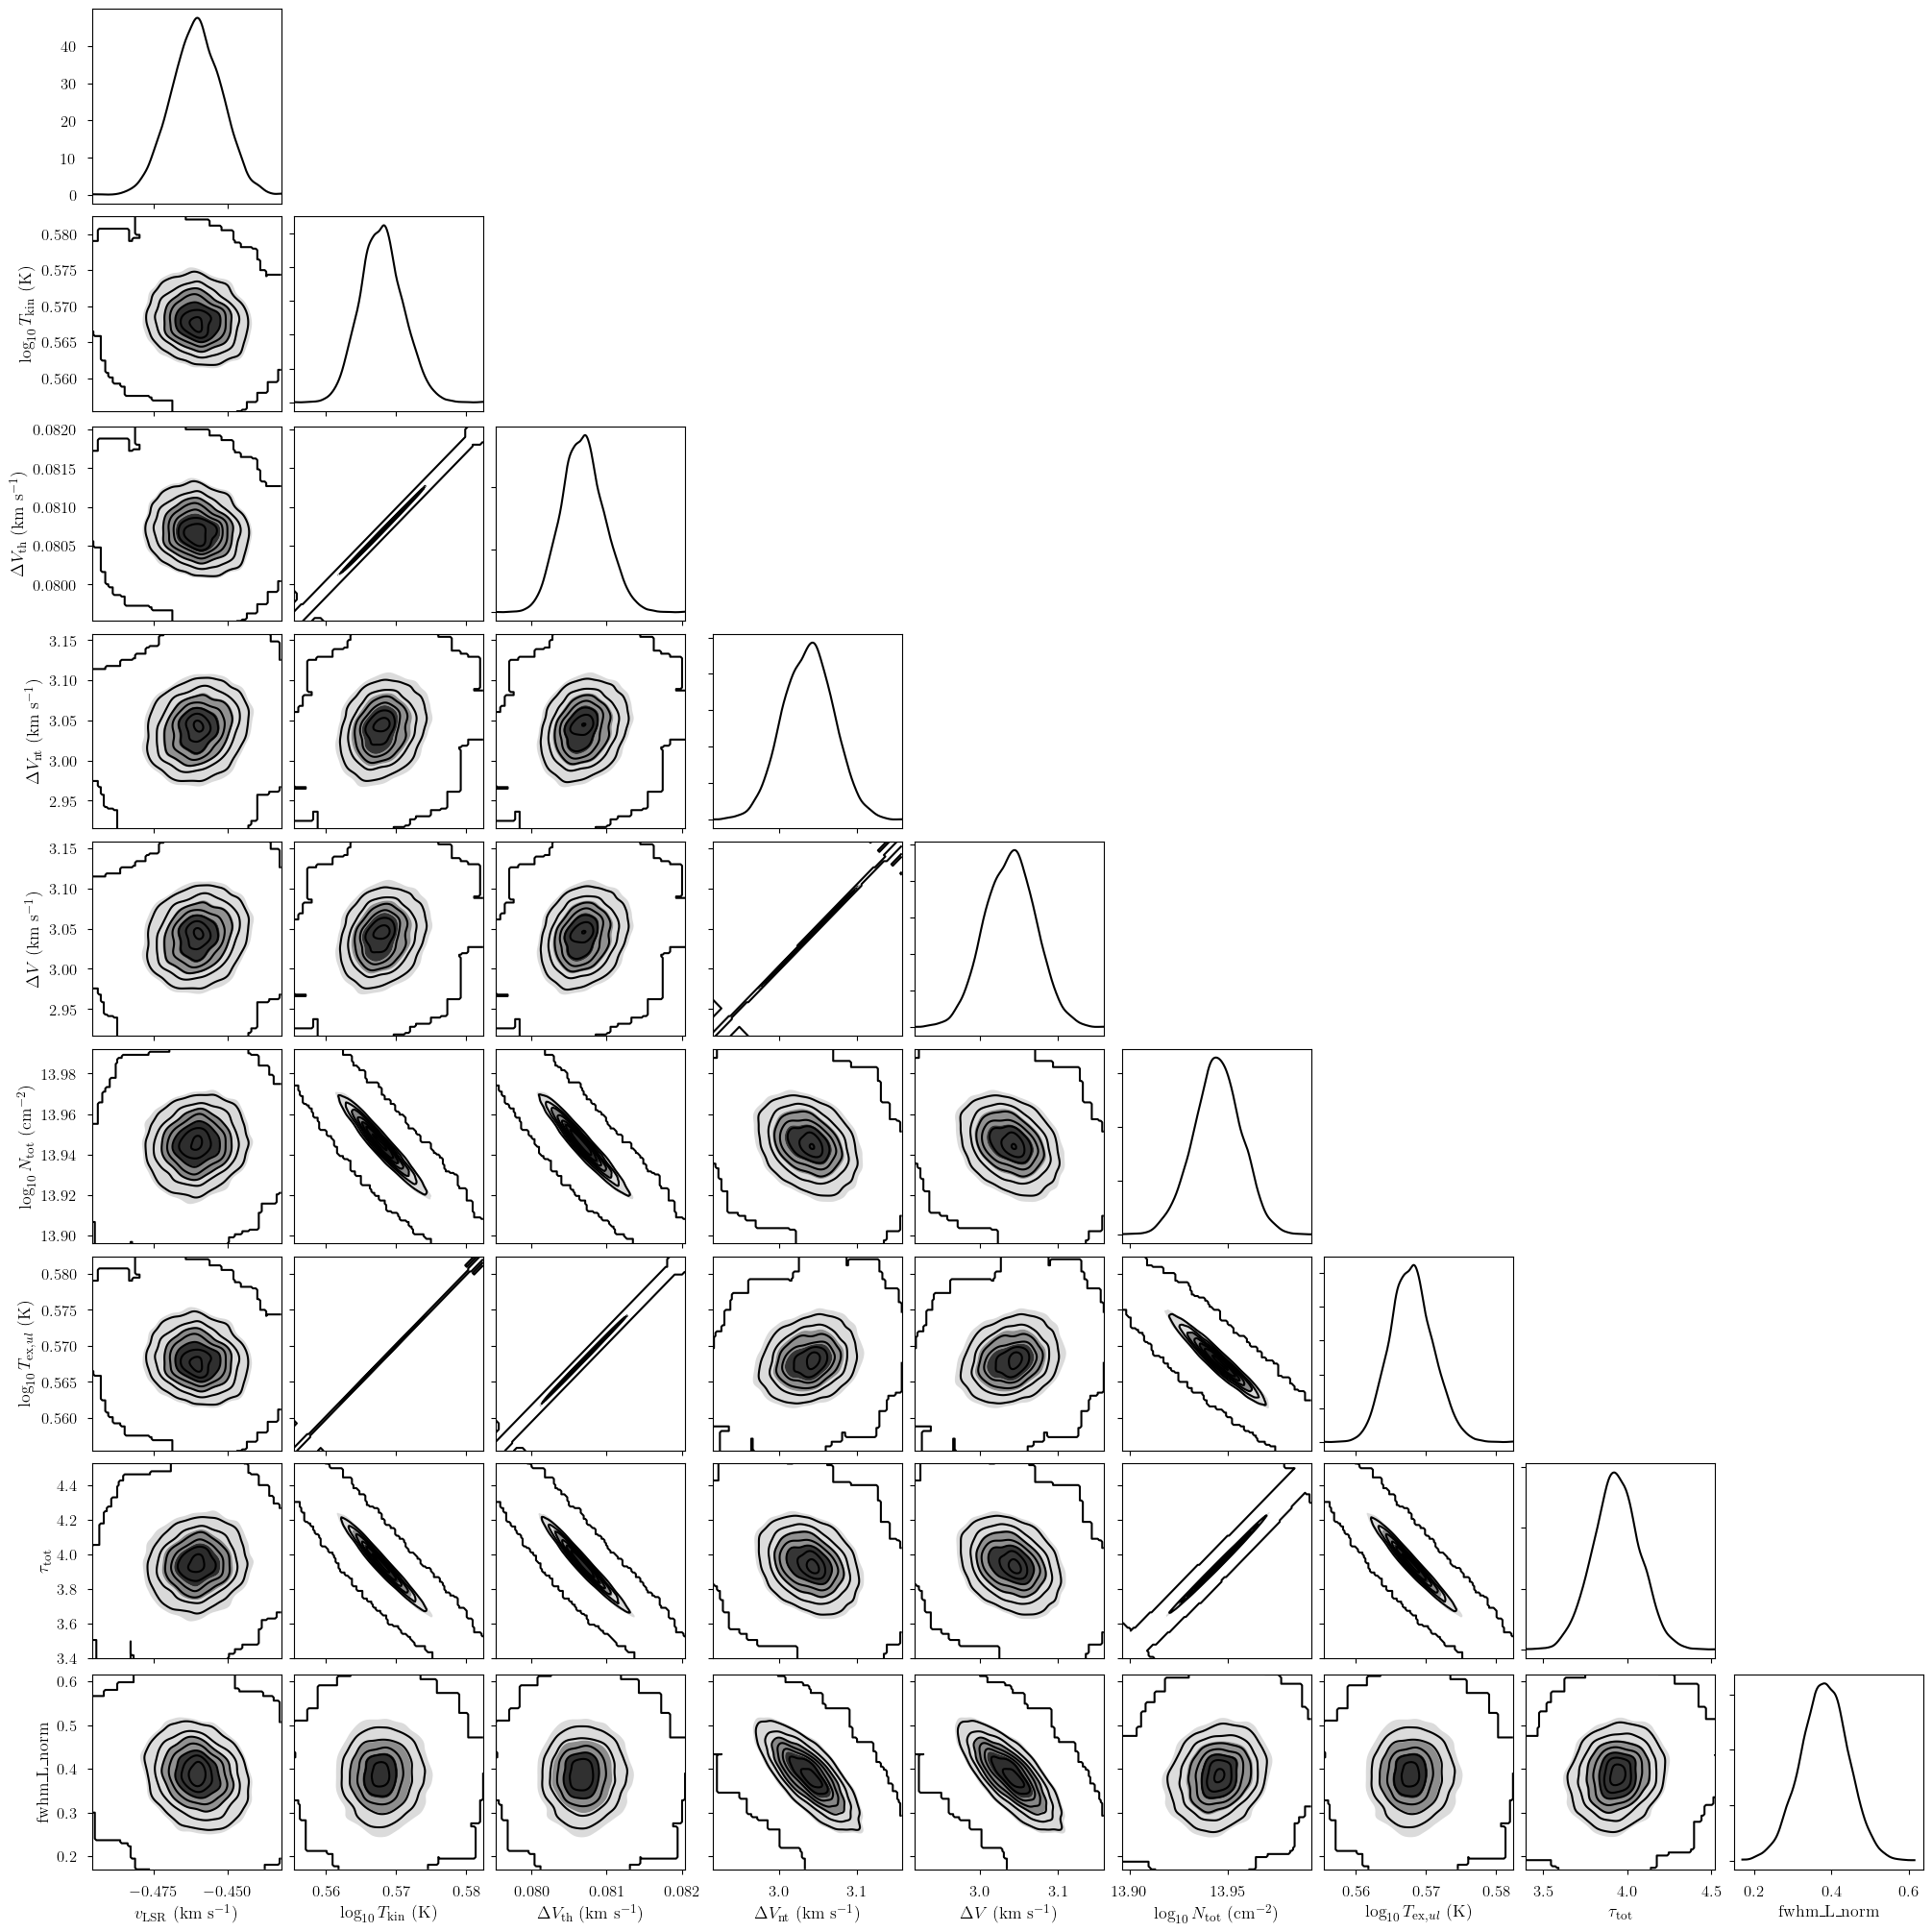

In [27]:
from bayes_spec.plots import plot_pair

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names + model.hyper_freeRVs, # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde",
)

We find a higher column density and optical depth, and smaller excitation temperature.

## Non-LTE model
Fix the kinetic temperature

In [28]:
# Initialize and define the model
baseline_degree = 0
n_clouds = 1
model = CNModel(
    data_12CN,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [13.75, 0.15], # mean and width of log10 total column density prior (cm-2)
    prior_log10_Tkin = [0.5, 0.15], # ignored because kinetic temperature is fixed
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log10_Tex = [0.5, 0.15], # mean and width of excitation temperature prior (K)
    assume_CTEX = False, # do not assume CTEX
    prior_LTE_precision = 100.0, # width of LTE precision prior
    fix_log10_Tkin = 1.5, # fix the kinetic temperature (K)
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Sampling: [12CN-1, 12CN-2, LTE_precision, baseline_12CN-1_norm, baseline_12CN-2_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N_norm, log10_Tex_ul_norm, velocity_norm, weights]


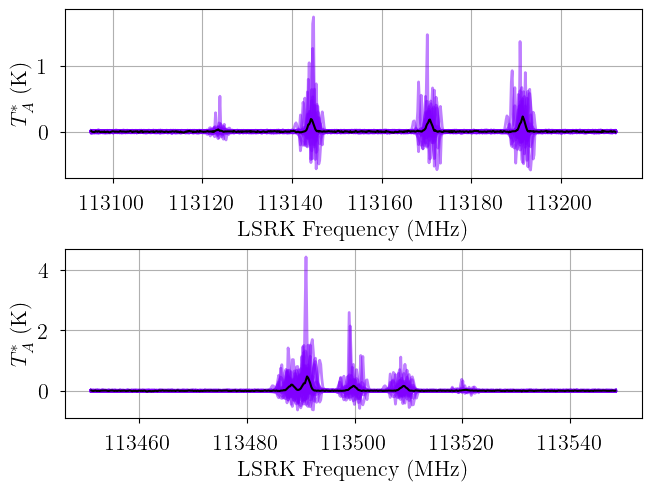

In [29]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [30]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.02, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 3900
Interrupted at 3,899 [3%]: Average Loss = 49,310


Output()

Runtime: 0.57 minutes


Sampling: [12CN-1, 12CN-2]


Output()

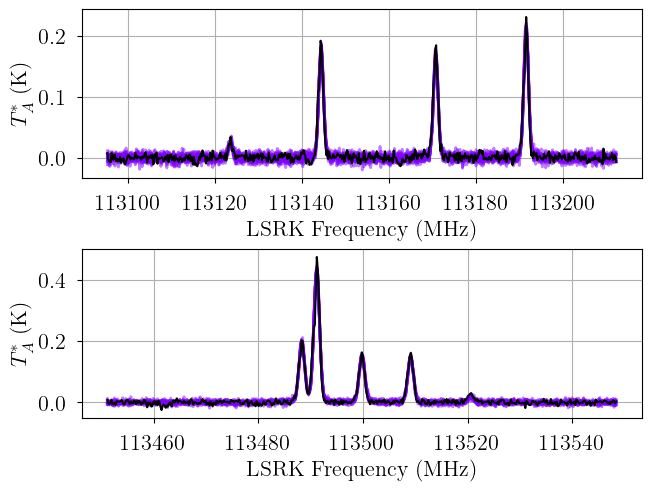

In [31]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [32]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 0.02}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3900
Interrupted at 3,899 [3%]: Average Loss = 49,310
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 416 seconds.


Adding log-likelihood to trace


Output()

Runtime: 7.93 minutes


In [33]:
model.solve()

GMM converged to unique solution


Sampling: [12CN-1, 12CN-2]


Output()

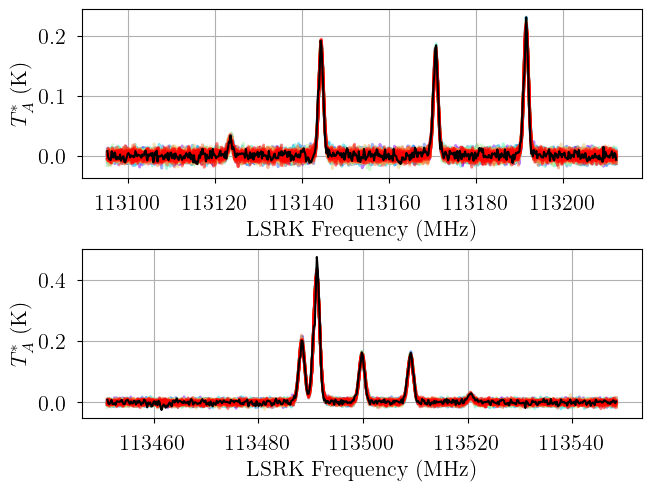

In [34]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [35]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

/home/twenger/miniconda3/envs/bayes_spec-dev/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
velocity[0]              -0.474  0.009  -0.490   -0.457      0.000    0.000   
fwhm_thermal[0]           0.236  0.000   0.236    0.236      0.000    0.000   
fwhm_nonthermal[0]        3.192  0.043   3.113    3.273      0.001    0.001   
fwhm[0]                   3.201  0.043   3.122    3.281      0.001    0.001   
log10_N[0]               13.614  0.061  13.503   13.730      0.002    0.001   
log10_Tex_ul[0]           0.732  0.057   0.628    0.835      0.001    0.001   
Tex[113123.3687, 0]       6.412  1.277   4.618    8.541      0.039    0.071   
Tex[113144.19, 0]         6.106  1.023   4.618    7.910      0.031    0.047   
Tex[113170.535, 0]        6.103  1.095   4.485    7.912      0.033    0.055   
Tex[113191.325, 0]        5.831  0.893   4.457    7.356      0.027    0.038   
Tex[113488.142, 0]        5.668  0.890   4.368    7.238      0.027    0.040   
Tex[113490.985, 0]        5.080  0.546   4.204    6.053      0.016    0.019   
Tex[113499.643, 0]        5.612  0.866   4.296    7.100      0.026    0.038   
Tex[113508.934, 0]        5.438  0.740   4.301    6.751      0.022    0.029   
Tex[113520.4215, 0]       5.387  0.726   4.291    6.705      0.022    0.028   
tau[113123.3687, 0]       0.014  0.004   0.006    0.021      0.000    0.000   
tau[113144.19, 0]         0.118  0.033   0.058    0.182      0.001    0.001   
tau[113170.535, 0]        0.112  0.033   0.051    0.173      0.001    0.001   
tau[113191.325, 0]        0.153  0.042   0.076    0.232      0.001    0.001   
tau[113488.142, 0]        0.151  0.043   0.072    0.230      0.001    0.001   
tau[113490.985, 0]        0.439  0.110   0.235    0.645      0.003    0.002   
tau[113499.643, 0]        0.120  0.034   0.056    0.182      0.001    0.001   
tau[113508.934, 0]        0.123  0.033   0.065    0.186      0.001    0.001   
tau[113520.4215, 0]       0.015  0.004   0.008    0.023      0.000    0.000   
tau_total[0]              1.246  0.335   0.636    1.880      0.010    0.006   
TR[113123.3687, 0]        4.087  1.218   2.387    6.075      0.037    0.071   
TR[113144.19, 0]          3.797  0.969   2.346    5.424      0.029    0.046   
TR[113170.535, 0]         3.795  1.038   2.305    5.505      0.031    0.055   
TR[113191.325, 0]         3.538  0.839   2.279    4.971      0.025    0.037   
TR[113488.142, 0]         3.383  0.835   2.116    4.772      0.025    0.039   
TR[113490.985, 0]         2.839  0.501   2.053    3.732      0.015    0.018   
TR[113499.643, 0]         3.331  0.811   2.112    4.700      0.025    0.037   
TR[113508.934, 0]         3.168  0.688   2.137    4.390      0.021    0.028   
TR[113520.4215, 0]        3.122  0.674   2.128    4.346      0.020    0.027   
fwhm_L                    0.467  0.074   0.329    0.607      0.001    0.001   
baseline_12CN-1_norm[0]  -0.202  0.043  -0.286   -0.123      0.001    0.001   
baseline_12CN-2_norm[0]  -0.357  0.051  -0.454   -0.263      0.001    0.001   

                         ess_bulk  ess_tail  r_hat  
velocity[0]                6128.0    5041.0   1.00  
fwhm_thermal[0]            8000.0    8000.0    NaN  
fwhm_nonthermal[0]         2272.0    3498.0   1.01  
fwhm[0]                    2272.0    3498.0   1.01  
log10_N[0]                 1168.0    1608.0   1.01  
log10_Tex_ul[0]            1564.0    2213.0   1.01  
Tex[113123.3687, 0]        1177.0    1609.0   1.01  
Tex[113144.19, 0]          1172.0    1604.0   1.01  
Tex[113170.535, 0]         1177.0    1596.0   1.01  
Tex[113191.325, 0]         1180.0    1620.0   1.01  
Tex[113488.142, 0]         1179.0    1606.0   1.01  
Tex[113490.985, 0]         1175.0    1583.0   1.01  
Tex[113499.643, 0]         1179.0    1580.0   1.01  
Tex[113508.934, 0]         1189.0    1653.0   1.01  
Tex[113520.4215, 0]        1199.0    1604.0   1.01  
tau[113123.3687, 0]        1170.0    1582.0   1.01  
tau[113144.19, 0]          1171.0    1592.0   1.01  
tau[113170.535, 0]         1172.0    1578.0   1.01  
tau[113191.325, 0

## Number of clouds

In [36]:
from bayes_spec import Optimize
from bayes_cn_hfs import CNModel

max_n_clouds = 5
baseline_degree = 0
opt = Optimize(
    CNModel,
    data_12CN,
    molecule="CN", # molecule name
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    max_n_clouds=max_n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
opt.add_priors(
    prior_log10_N = [13.75, 0.15], # mean and width of log10 total column density prior (cm-2)
    prior_log10_Tkin = [0.5, 0.15], # ignored because kinetic temperature is fixed
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log10_Tex = [0.5, 0.15], # mean and width of excitation temperature prior (K)
    assume_CTEX = False, # do not assume CTEX
    prior_LTE_precision = 100.0, # width of LTE precision prior
    fix_log10_Tkin = 1.5, # fix the kinetic temperature (K)
    ordered = False, # do not assume optically-thin
)
opt.add_likelihood()

Sampling: [12CN-1, 12CN-2, LTE_precision, baseline_12CN-1_norm, baseline_12CN-2_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N_norm, log10_Tex_ul_norm, velocity_norm, weights]


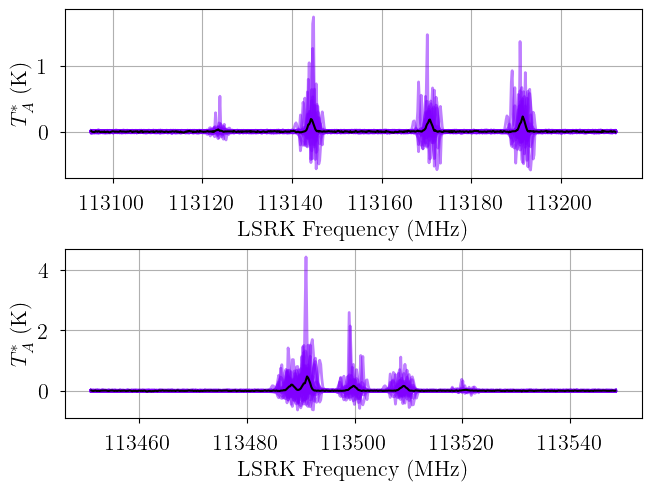

In [37]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = opt.models[1].sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(opt.models[1].data, prior.prior_predictive)

In [38]:
start = time.time()
fit_kwargs = {
    "n": 100_000,
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 0.02,
}
opt.fit_all(**fit_kwargs)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Null hypothesis BIC = 5.117e+04
Approximating n_cloud = 1 posterior...


Output()

Convergence achieved at 3900
Interrupted at 3,899 [3%]: Average Loss = 49,310


Output()

n_cloud = 1 BIC = -7.361e+03

Approximating n_cloud = 2 posterior...


Output()

Convergence achieved at 4100
Interrupted at 4,099 [4%]: Average Loss = 22,111


Output()

n_cloud = 2 BIC = -7.785e+03

Approximating n_cloud = 3 posterior...


Output()

Convergence achieved at 8900
Interrupted at 8,899 [8%]: Average Loss = 51,536


Output()

n_cloud = 3 BIC = -7.850e+03

Approximating n_cloud = 4 posterior...


Output()

Convergence achieved at 25000
Interrupted at 24,999 [24%]: Average Loss = 1.6998e+05


Output()

n_cloud = 4 BIC = -7.608e+03

Approximating n_cloud = 5 posterior...


Output()

Convergence achieved at 15700
Interrupted at 15,699 [15%]: Average Loss = 21,980


Output()

n_cloud = 5 BIC = -7.617e+03

Runtime: 3.49 minutes


[51174.07284797 -7360.88225312 -7784.60436823 -7850.18066391
 -7608.0480837  -7616.8592235 ]


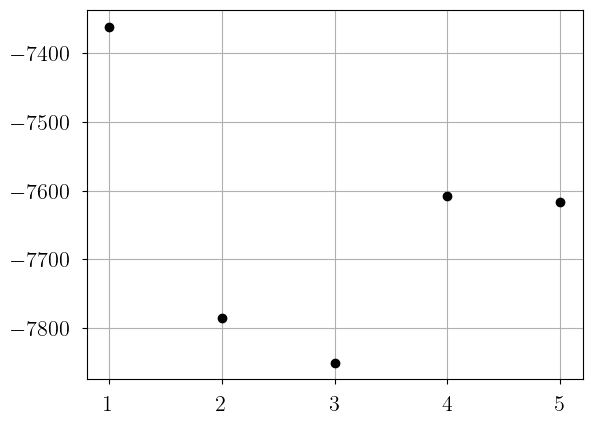

In [39]:
null_bic = opt.models[1].null_bic()
n_clouds = np.arange(max_n_clouds+1)
bics_vi = np.array([null_bic] + [model.bic(chain=0) for model in opt.models.values()])
print(bics_vi)

plt.plot(n_clouds[1:], bics_vi[1:], 'ko')

In [40]:
start = time.time()
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 0.02,
}
sample_kwargs = {
    "chains": 8,
    "cores": 8,
    "n_init": 100_000,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.8},
}
opt.optimize(fit_kwargs=fit_kwargs, sample_kwargs=sample_kwargs, approx=False)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Null hypothesis BIC = 5.117e+04
Sampling n_cloud = 1 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3900
Interrupted at 3,899 [3%]: Average Loss = 49,310
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 525 seconds.


Adding log-likelihood to trace


Output()

GMM converged to unique solution
n_cloud = 1 solution = 0 BIC = -7.375e+03

Sampling n_cloud = 2 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 4100
Interrupted at 4,099 [4%]: Average Loss = 22,111
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 763 seconds.


Adding log-likelihood to trace


Output()

There were 11 divergences in converged chains.
GMM converged to unique solution
n_cloud = 2 solution = 0 BIC = -8.070e+03

Sampling n_cloud = 3 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 8900
Interrupted at 8,899 [8%]: Average Loss = 51,536
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 1683 seconds.


Adding log-likelihood to trace


Output()

There were 29 divergences in converged chains.
GMM found 2 unique solutions
Solution 0: chains [np.int64(0), np.int64(3), np.int64(5), np.int64(7)]
Solution 1: chains [np.int64(1), np.int64(2), np.int64(4), np.int64(6)]
n_cloud = 3 solution = 0 BIC = -8.017e+03
n_cloud = 3 solution = 1 BIC = -8.008e+03

Stopping criteria met.
Sampling n_cloud = 4 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 25000
Interrupted at 24,999 [24%]: Average Loss = 1.6998e+05
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 1719 seconds.


Adding log-likelihood to trace


Output()

There were 125 divergences in converged chains.
GMM converged to unique solution
6 of 8 chains appear converged.
n_cloud = 4 solution = 0 BIC = -7.976e+03

Stopping criteria met.
Stopping early.
Runtime: 81.41 minutes


There is not a unique solution. Must supply solution.
No solutions. Try solve()
[51174.07284797 -7374.78641935 -8069.69784204            inf
 -7976.10082054            inf]


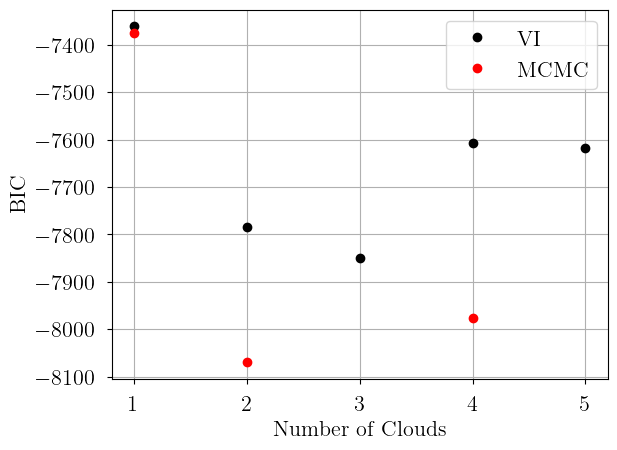

In [41]:
null_bic = opt.models[1].null_bic()
n_clouds = np.arange(max_n_clouds+1)
bics_mcmc = np.array([null_bic] + [model.bic() for model in opt.models.values()])
print(bics_mcmc)

plt.plot(n_clouds[1:], bics_vi[1:], 'ko', label="VI")
plt.plot(n_clouds[1:], bics_mcmc[1:], 'ro', label="MCMC")
plt.xlabel("Number of Clouds")
plt.ylabel("BIC")
_ = plt.legend()

In [42]:
model = opt.best_model
print(model.n_clouds)
model.solve()

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
]
pm.summary(model.trace.solution_0, var_names=var_names + ["LTE_precision"] + model.hyper_freeRVs + model.hyper_deterministics + model.baseline_freeRVs)

2
GMM converged to unique solution


/home/twenger/miniconda3/envs/bayes_spec-dev/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
velocity[0]               0.553  0.044   0.470    0.636      0.001    0.001   
velocity[1]              -0.316  0.014  -0.342   -0.291      0.000    0.000   
fwhm_thermal[0]           0.236  0.000   0.236    0.236      0.000    0.000   
fwhm_thermal[1]           0.236  0.000   0.236    0.236      0.000    0.000   
fwhm_nonthermal[0]        0.926  0.096   0.741    1.100      0.002    0.001   
fwhm_nonthermal[1]        3.120  0.039   3.044    3.191      0.001    0.000   
fwhm[0]                   0.956  0.093   0.777    1.125      0.002    0.001   
fwhm[1]                   3.129  0.039   3.053    3.200      0.001    0.000   
log10_N[0]               13.474  0.117  13.257   13.689      0.003    0.002   
log10_N[1]               13.628  0.058  13.519   13.737      0.002    0.001   
log10_Tex_ul[0]           0.455  0.015   0.427    0.485      0.000    0.000   
log10_Tex_ul[1]           0.751  0.058   0.654    0.864      0.001    0.001   
Tex[113123.3687, 0]       2.825  0.056   2.721    2.920      0.001    0.001   
Tex[113123.3687, 1]       6.371  1.213   4.720    8.534      0.032    0.042   
Tex[113144.19, 0]         2.817  0.049   2.724    2.895      0.001    0.001   
Tex[113144.19, 1]         6.154  1.019   4.661    8.003      0.027    0.029   
Tex[113170.535, 0]        2.789  0.060   2.678    2.884      0.002    0.002   
Tex[113170.535, 1]        6.203  1.112   4.650    8.164      0.029    0.037   
Tex[113191.325, 0]        2.782  0.057   2.680    2.873      0.002    0.002   
Tex[113191.325, 1]        6.001  0.944   4.577    7.700      0.025    0.026   
Tex[113488.142, 0]        2.786  0.054   2.686    2.872      0.002    0.002   
Tex[113488.142, 1]        5.755  0.899   4.456    7.386      0.024    0.027   
Tex[113490.985, 0]        2.946  0.074   2.810    3.059      0.002    0.002   
Tex[113490.985, 1]        5.504  0.668   4.488    6.742      0.018    0.017   
Tex[113499.643, 0]        2.789  0.049   2.696    2.869      0.001    0.001   
Tex[113499.643, 1]        5.630  0.845   4.371    7.139      0.022    0.024   
Tex[113508.934, 0]        2.778  0.054   2.678    2.864      0.001    0.002   
Tex[113508.934, 1]        5.586  0.778   4.380    7.004      0.020    0.020   
Tex[113520.4215, 0]       2.782  0.053   2.680    2.870      0.001    0.001   
Tex[113520.4215, 1]       5.471  0.740   4.315    6.817      0.019    0.019   
tau[113123.3687, 0]       0.021  0.005   0.012    0.031      0.000    0.000   
tau[113123.3687, 1]       0.014  0.004   0.006    0.021      0.000    0.000   
tau[113144.19, 0]         0.176  0.044   0.100    0.262      0.001    0.001   
tau[113144.19, 1]         0.118  0.033   0.055    0.177      0.001    0.000   
tau[113170.535, 0]        0.172  0.043   0.098    0.254      0.001    0.001   
tau[113170.535, 1]        0.113  0.032   0.053    0.173      0.001    0.000   
tau[113191.325, 0]        0.225  0.056   0.129    0.334      0.001    0.001   
tau[113191.325, 1]        0.152  0.041   0.071    0.226      0.001    0.001   
tau[113488.142, 0]        0.224  0.056   0.126    0.330      0.001    0.001   
tau[113488.142, 1]        0.153  0.042   0.075    0.232      0.001    0.001   
tau[113490.985, 0]        0.587  0.145   0.342    0.873      0.004    0.002   
tau[113490.985, 1]        0.424  0.108   0.233    0.634      0.003    0.002   
tau[113499.643, 0]        0.177  0.044   0.099    0.261      0.001    0.001   
tau[113499.643, 1]        0.122  0.033   0.060    0.184      0.001    0.000   
tau[113508.934, 0]        0.174  0.043   0.101    0.260      0.001    0.001   
tau[113508.934, 1]        0.122  0.032   0.061    0.181      0.001    0.000   
tau[113520.4215, 0]       0.022  0.005   0.013    0.033      0.000    0.000   
tau[113520.4215, 1]       0.015  0.004   0.008    0.023      0.000    0.000   
tau_total[0]              1.778  0.440   1.036    2.654      0.012    0.006   
tau_total[1]              1.234  0.329   0.616    1.839      0.009    0.005  

Sampling: [12CN-1, 12CN-2]


Output()

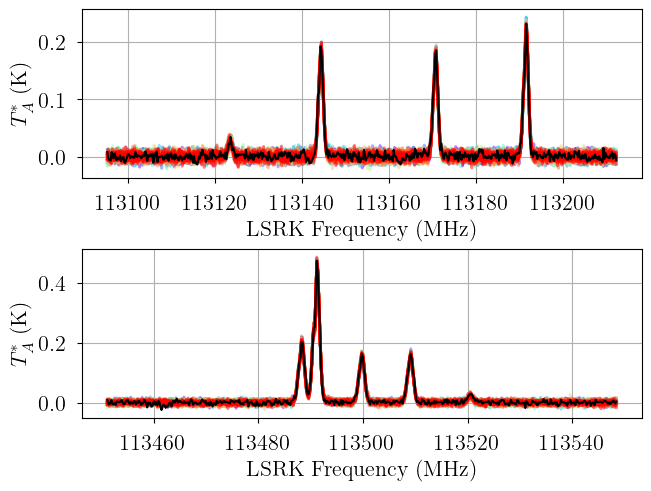

In [43]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

['velocity_norm', 'fwhm_nonthermal_norm', 'log10_N_norm', 'log10_Tex_ul_norm', 'LTE_precision', 'weights']


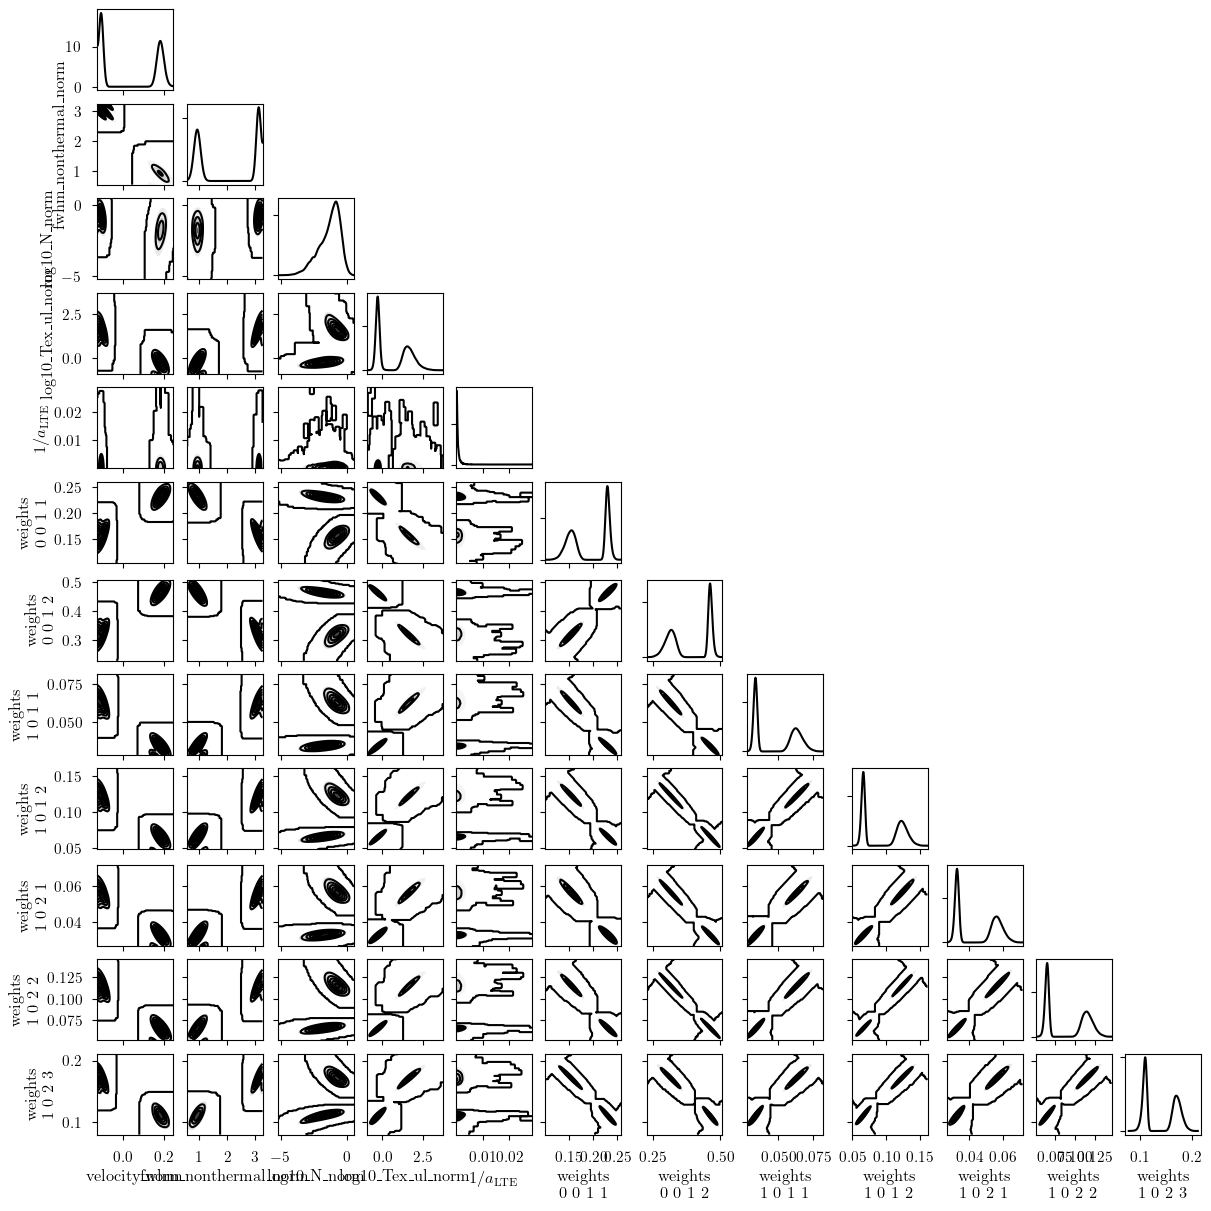

In [44]:
from bayes_spec.plots import plot_pair

var_names = [
    param for param in model.cloud_freeRVs
]
print(var_names)
axes = plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
)
_ = axes.ravel()[0].figure.set_size_inches(12, 12)

['velocity', 'fwhm_nonthermal', 'fwhm', 'log10_N', 'log10_Tex_ul', 'tau_total']


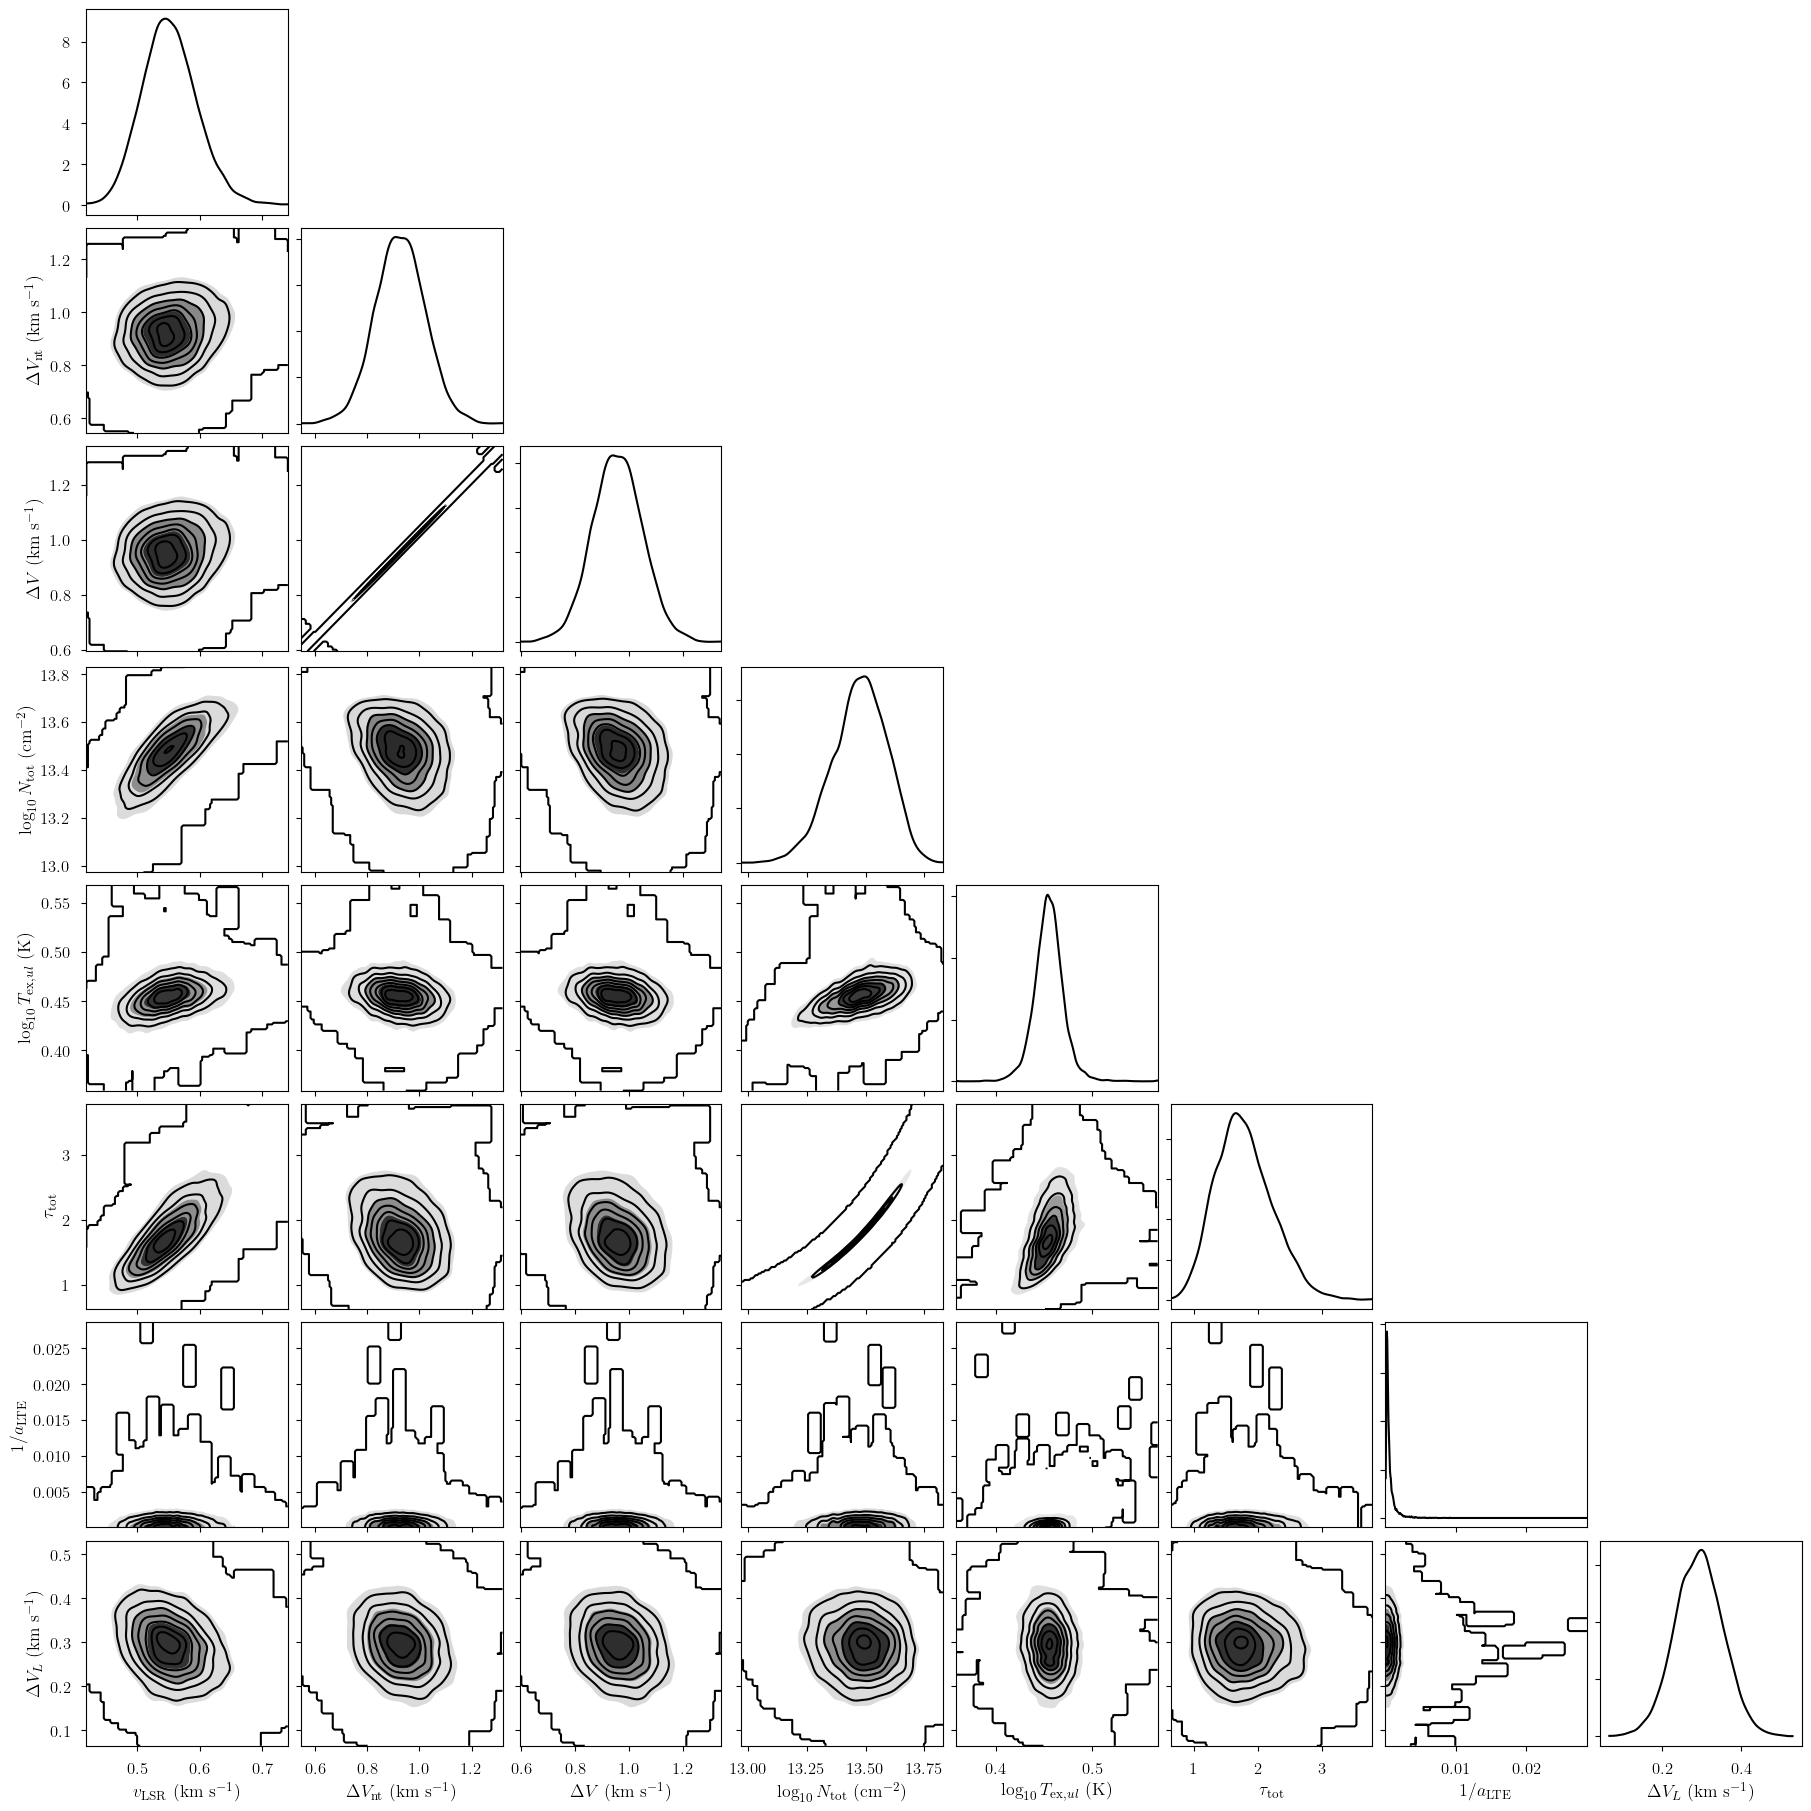

In [45]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
    and param not in ["fwhm_thermal"]
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names + ["LTE_precision"] + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
)

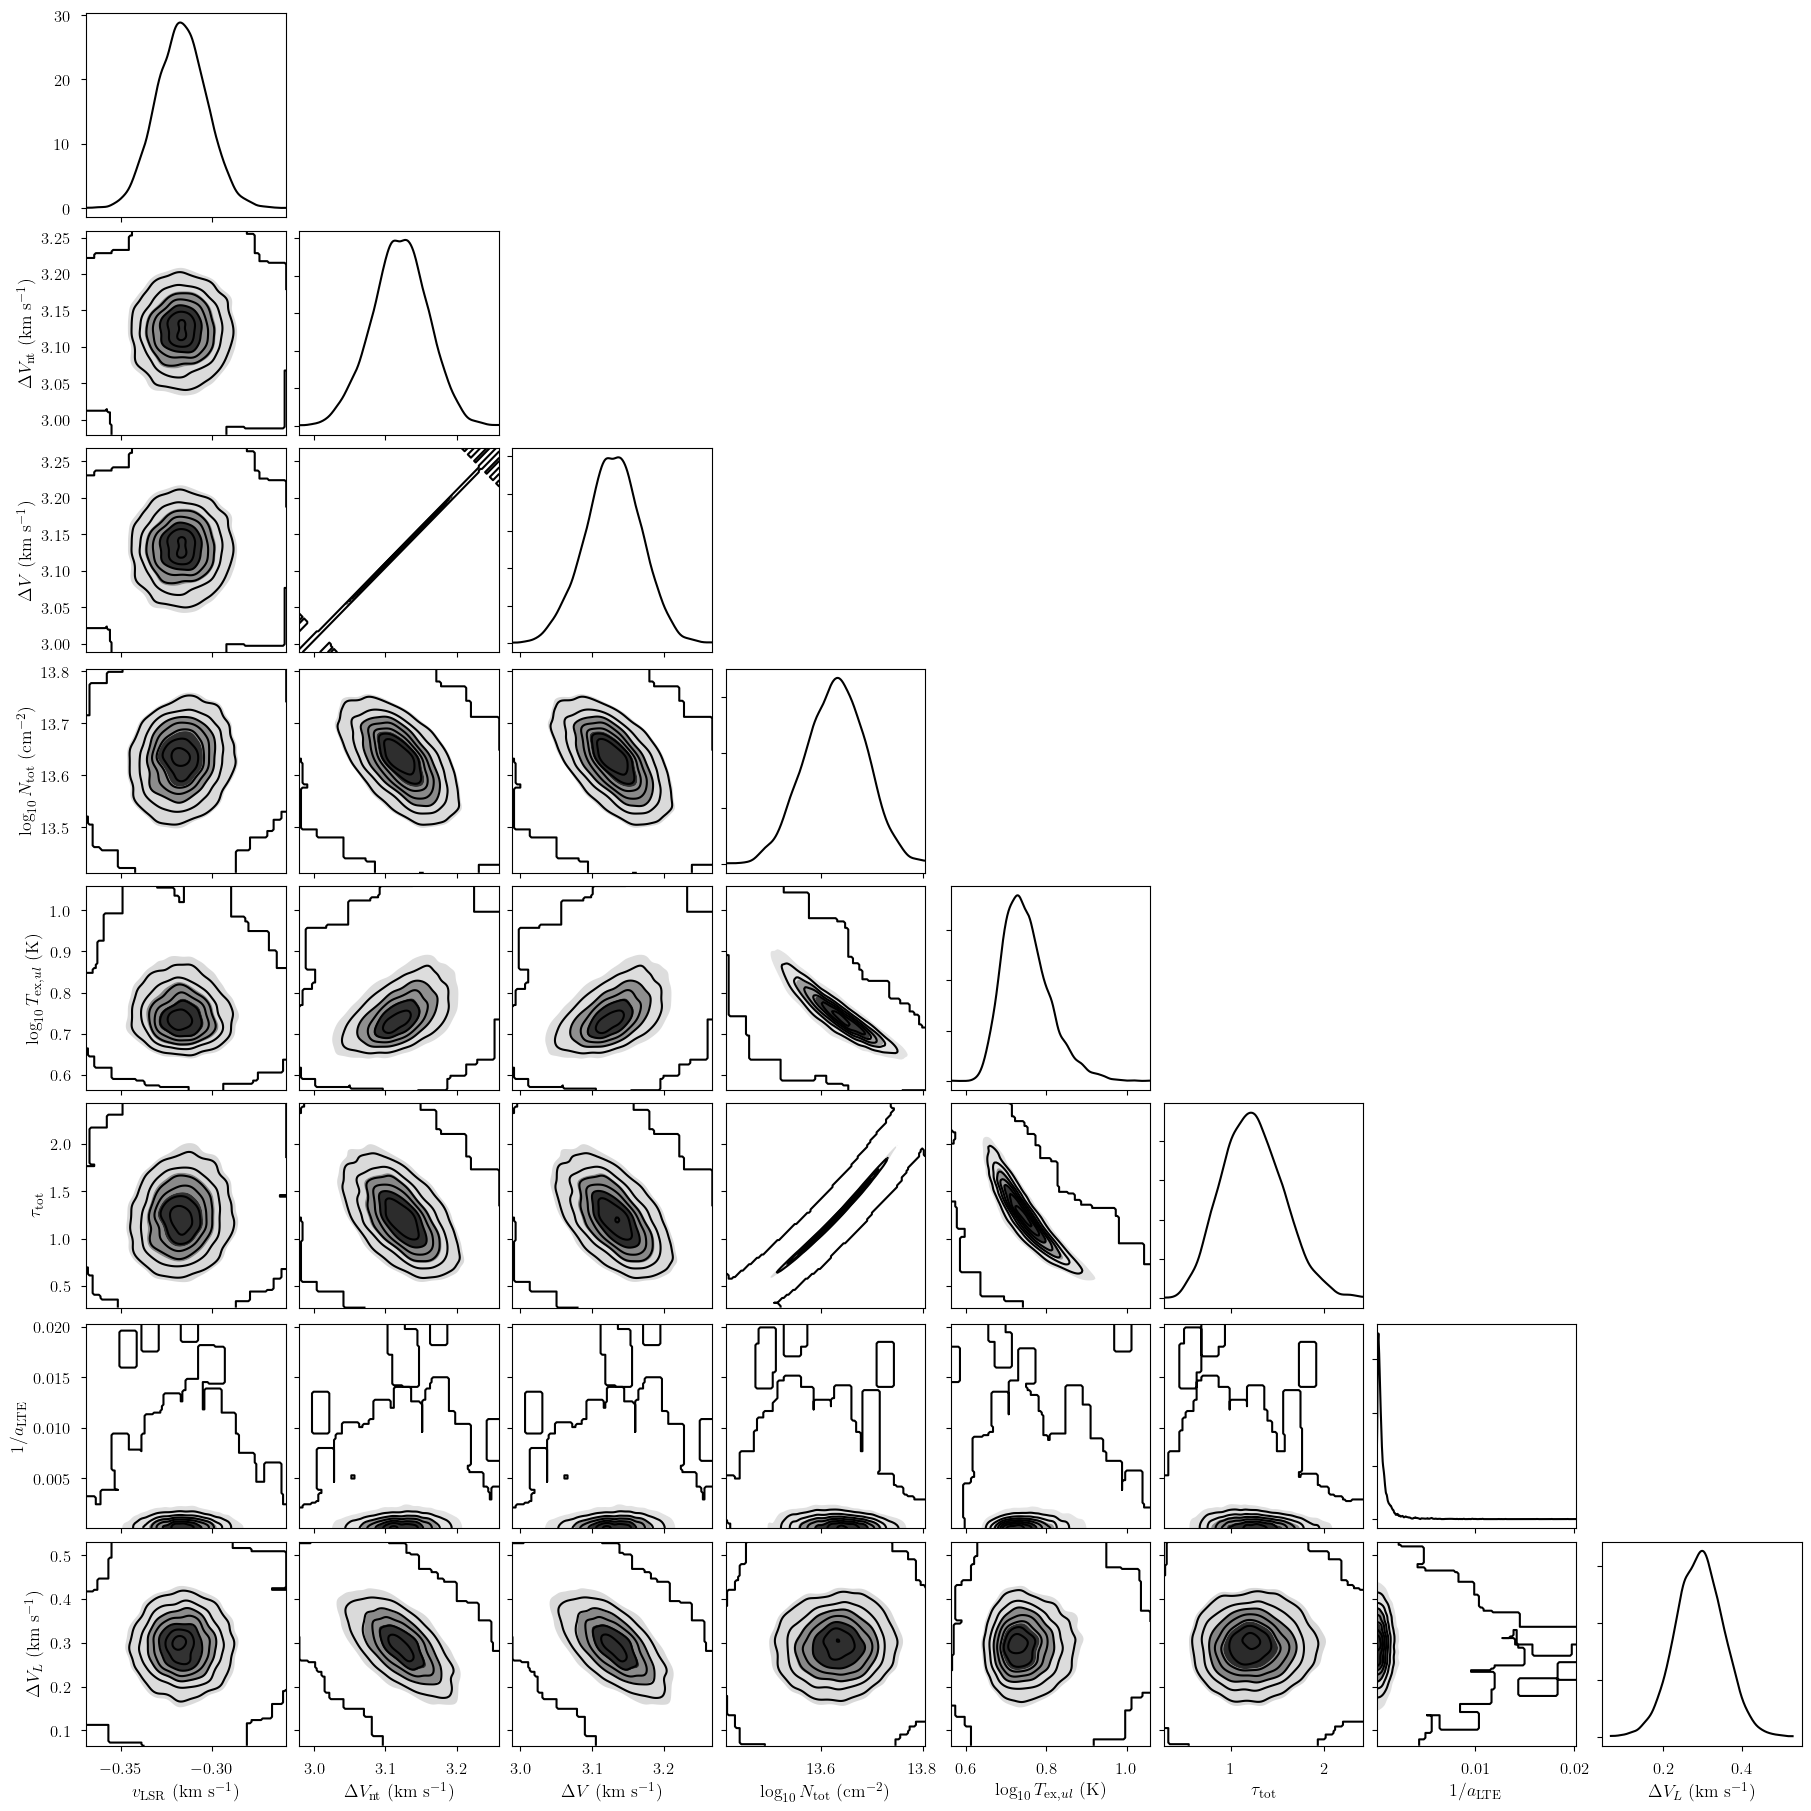

In [46]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1), # samples
    var_names + ["LTE_precision"] + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
)

## Ratio Model
We assume CTEX for 13CN.

In [47]:
from bayes_cn_hfs.cn_ratio_model import CNRatioModel

# Initialize and define the model
n_clouds = 2 # number of cloud components
baseline_degree = 0 # polynomial baseline degree
model = CNRatioModel(
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [13.50, 0.25], # mean and width of log10 12CN total column density prior (cm-2)
    prior_ratio_12C_13C = [50.0, 25.0], # mean and width of 12C/13C ratio prior
    prior_log10_Tkin = None, # kinetic temperature is fixed
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log10_Tex = [0.6, 0.15], # mean and width of excitation temperature prior (K)
    assume_CTEX_12CN = False, # do not assume CTEX
    prior_LTE_precision = 100.0, # width of LTE precision prior
    assume_CTEX_13CN = True, # assume CTEX for 13CN
    fix_log10_Tkin = 1.5, # kinetic temperature is fixed (K)
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Sampling: [12CN-1, 12CN-2, 13CN-1, 13CN-2, LTE_precision, baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN-1_norm, baseline_13CN-2_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N_12CN_norm, log10_Tex_ul_norm, ratio_12C_13C, velocity_norm, weights_12CN]


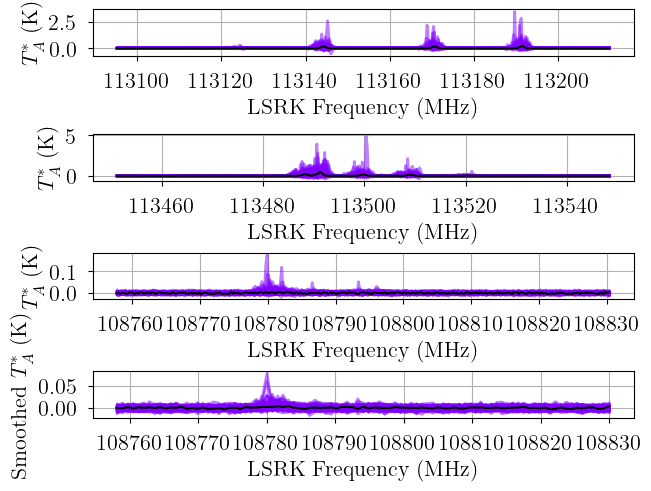

In [48]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [ ]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.02, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

In [ ]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [ ]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 0.02}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.9}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

In [ ]:
model.solve(kl_div_threshold=0.1)

In [52]:
print("solutions:", model.solutions)

pm.summary(model.trace.solution_0)

solutions: [0, 1]


/opt/conda/envs/bayes_cn_hfs-dev/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean            sd        hdi_3%  \
baseline_12CN-1_norm[0]  -1.810000e-01  4.200000e-02 -2.590000e-01   
baseline_12CN-2_norm[0]  -3.450000e-01  5.000000e-02 -4.370000e-01   
baseline_13CN_norm[0]     8.000000e-03  5.300000e-02 -8.800000e-02   
velocity_norm[0]         -2.690000e-01  6.000000e-03 -2.820000e-01   
velocity_norm[1]         -8.400000e-02  7.000000e-03 -9.600000e-02   
log10_N_12CN_norm[0]     -2.382000e+00  4.890000e-01 -3.295000e+00   
log10_N_12CN_norm[1]      3.536000e+00  1.680000e-01  3.224000e+00   
log10_Tex_ul_norm[0]      6.270000e-01  5.710000e-01 -3.460000e-01   
log10_Tex_ul_norm[1]     -7.710000e-01  4.200000e-02 -8.460000e-01   
fwhm_nonthermal_norm[0]   1.567000e+00  7.500000e-02  1.422000e+00   
fwhm_nonthermal_norm[1]   3.082000e+00  6.500000e-02  2.964000e+00   
fwhm_L_norm               1.890000e-01  4.700000e-02  1.010000e-01   
ratio_12C_13C[0]          6.556300e+01  2.520900e+01  2.604000e+01   
ratio_12C_13C[1]          1.018490e+02  2.366400e+01  6.081000e+01   
LTE_precision[0]          6.000000e-03  4.000000e-03  1.000000e-03   
LTE_precision[1]          0.000000e+00  0.000000e+00  0.000000e+00   
weights_12CN[0, 0 0 1 1]  1.650000e-01  2.000000e-02  1.280000e-01   
weights_12CN[0, 0 0 1 2]  3.250000e-01  3.600000e-02  2.560000e-01   
weights_12CN[0, 1 0 1 1]  4.700000e-02  5.000000e-03  3.800000e-02   
weights_12CN[0, 1 0 1 2]  1.100000e-01  1.200000e-02  9.000000e-02   
weights_12CN[0, 1 0 2 1]  4.600000e-02  5.000000e-03  3.600000e-02   
weights_12CN[0, 1 0 2 2]  9.800000e-02  9.000000e-03  8.200000e-02   
weights_12CN[0, 1 0 2 3]  2.090000e-01  2.500000e-02  1.660000e-01   
weights_12CN[1, 0 0 1 1]  2.210000e-01  1.000000e-03  2.180000e-01   
weights_12CN[1, 0 0 1 2]  4.430000e-01  2.000000e-03  4.390000e-01   
weights_12CN[1, 1 0 1 1]  3.800000e-02  1.000000e-03  3.700000e-02   
weights_12CN[1, 1 0 1 2]  7.500000e-02  1.000000e-03  7.400000e-02   
weights_12CN[1, 1 0 2 1]  3.600000e-02  0.000000e+00  3.600000e-02   
weights_12CN[1, 1 0 2 2]  7.300000e-02  1.000000e-03  7.200000e-02   
weights_12CN[1, 1 0 2 3]  1.140000e-01  1.000000e-03  1.120000e-01   
velocity[0]              -8.080000e-01  1.900000e-02 -8.460000e-01   
velocity[1]              -2.530000e-01  2.000000e-02 -2.880000e-01   
fwhm_thermal_12CN[0]      2.360000e-01  0.000000e+00  2.360000e-01   
fwhm_thermal_12CN[1]      2.360000e-01  0.000000e+00  2.360000e-01   
fwhm_thermal_13CN[0]      2.320000e-01  0.000000e+00  2.320000e-01   
fwhm_thermal_13CN[1]      2.320000e-01  0.000000e+00  2.320000e-01   
fwhm_nonthermal[0]        1.567000e+00  7.500000e-02  1.422000e+00   
fwhm_nonthermal[1]        3.082000e+00  6.500000e-02  2.964000e+00   
fwhm_12CN[0]              1.585000e+00  7.400000e-02  1.441000e+00   
fwhm_12CN[1]              3.091000e+00  6.400000e-02  2.973000e+00   
fwhm_13CN[0]              1.584000e+00  7.400000e-02  1.440000e+00   
fwhm_13CN[1]              3.090000e+00  6.400000e-02  2.973000e+00   
fwhm_L                    1.890000e-01  4.700000e-02  1.010000e-01   
log10_N_12CN[0]           1.290400e+01  1.220000e-01  1.267600e+01   
log10_N_12CN[1]           1.438400e+01  4.200000e-02  1.430600e+01   
N_13CN[0]                 1.455784e+11  6.921605e+10  4.240221e+10   
N_13CN[1]                 2.511788e+12  6.236147e+11  1.520469e+12   
log10_Tex_ul[0]           6.940000e-01  8.600000e-02  5.480000e-01   
log10_Tex_ul[1]           4.840000e-01  6.000000e-03  4.730000e-01   
Tex_12CN[113123.3687, 0]  4.517000e+00  2.439000e+00  3.233000e+00   
Tex_12CN[113123.3687, 1]  3.088000e+00  3.300000e-02  3.028000e+00   
Tex_12CN[113144.19, 0]    4.560000e+00  2.625000e+00  3.352000e+00   
Tex_12CN[113144.19, 1]    3.084000e+00  3.000000e-02  3.027000e+00   
Tex_12CN[113170.535, 0]   5.282000e+00  3.415000e+00  3.547000e+00   
Tex_12CN[113170.535, 1]   3.062000e+00  2.800000e-02  3.014000e+00   
Tex_12CN[113191.325, 0]   5.287000e+00  1.923000e+00  3.570000e+00   
Tex_12CN[113191.325, 1]   3.058000e+00  2.60

Sampling: [12CN-1, 12CN-2, 13CN]


Output()

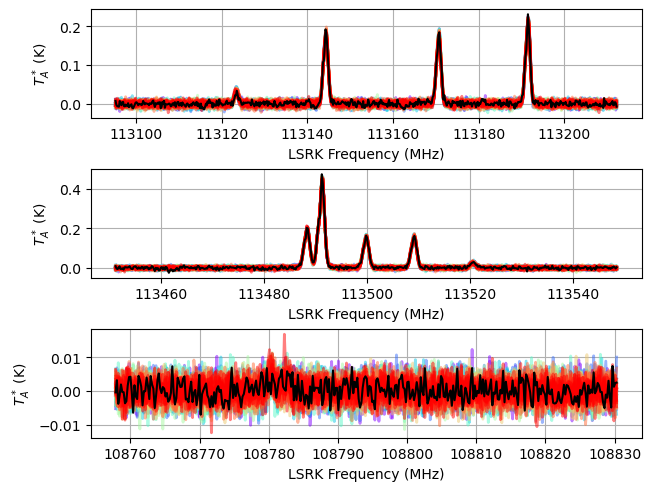

In [53]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [54]:
# 12C/13C ratio over all clouds
for solution in model.solutions:
    model.trace[f"solution_{solution}"]["ratio_12C_13C_total"] = (
        (10.0**model.trace[f"solution_{solution}"]["log10_N_12CN"]).sum(dim="cloud") / 
    model.trace[f"solution_{solution}"]["N_13CN"].sum(dim="cloud")
    )
    

In [55]:
pm.summary(model.trace.solution_0, var_names=["ratio_12C_13C_total"])

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
ratio_12C_13C_total  98.85  21.158  63.583  140.523      0.301    0.215   

                     ess_bulk  ess_tail  r_hat  
ratio_12C_13C_total    4964.0    4081.0    1.0

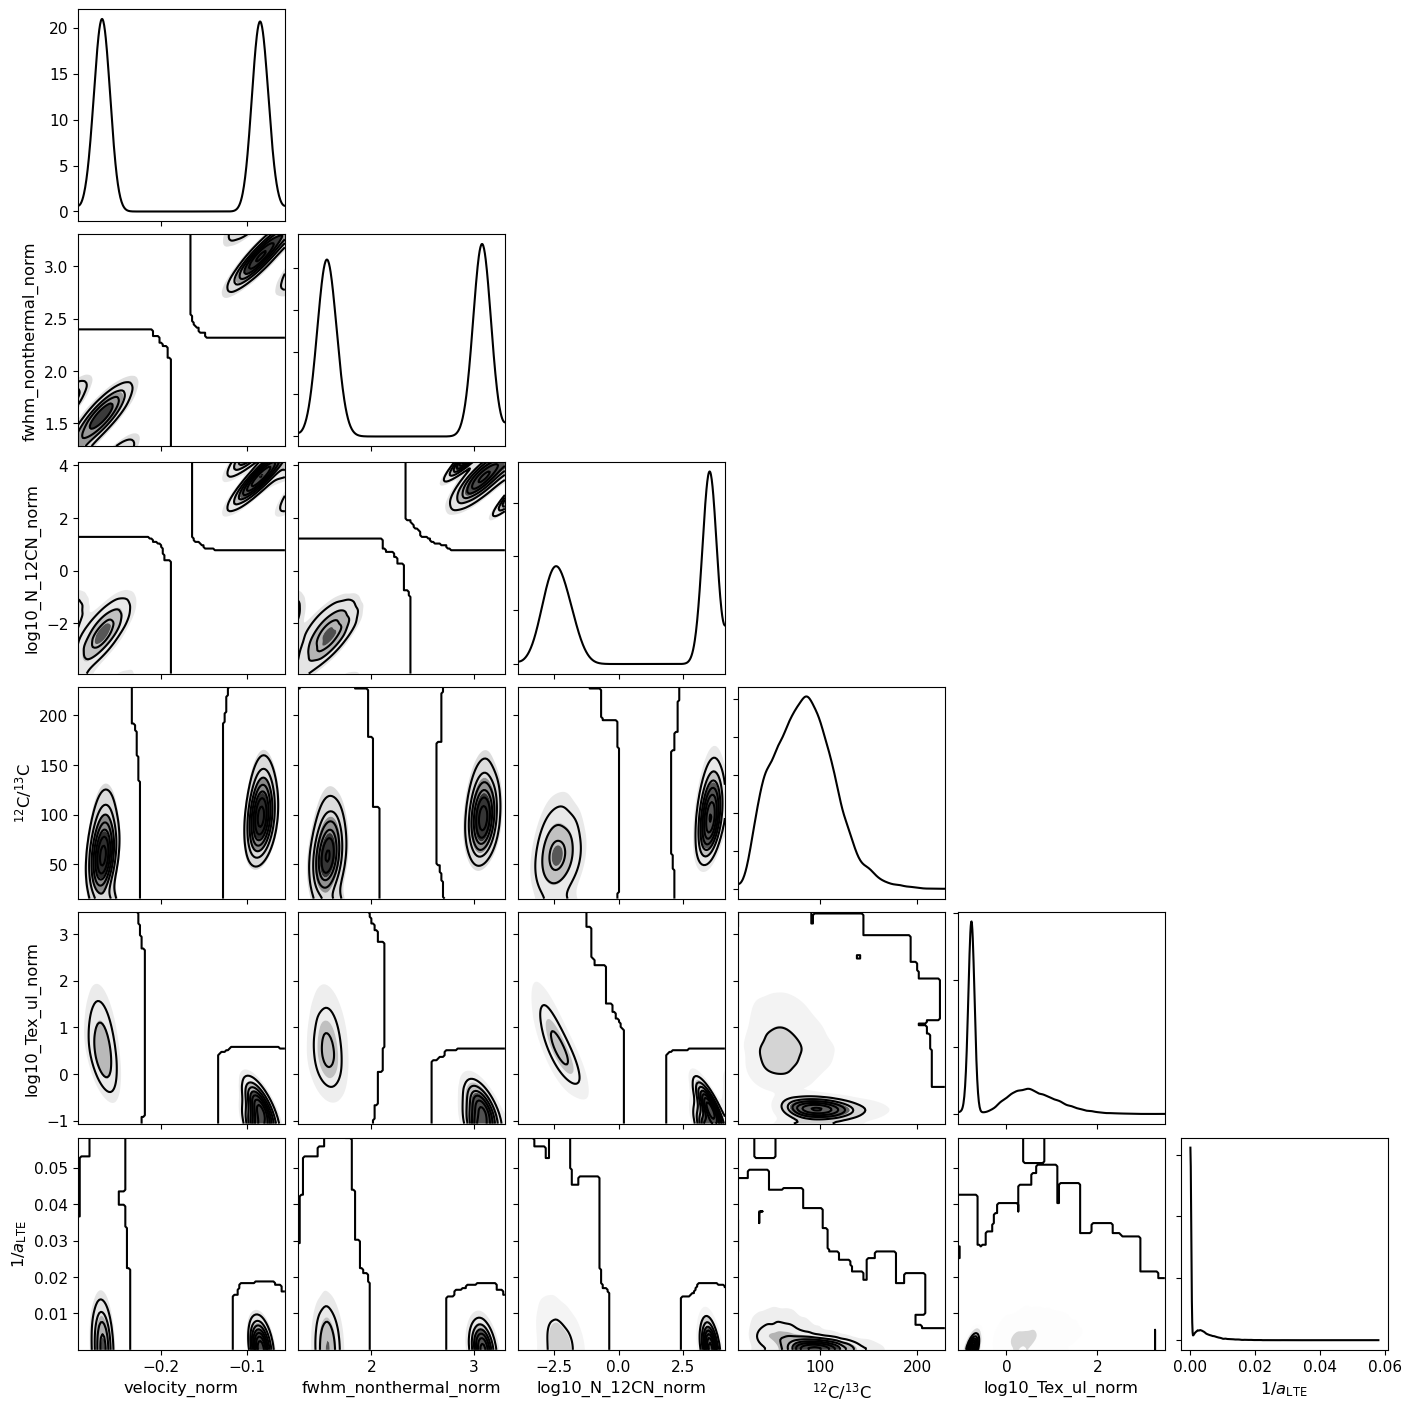

In [56]:
from bayes_spec.plots import plot_pair

var_names = [
    param for param in model.cloud_freeRVs
    if not set(model.model.named_vars_to_dims[param]).intersection(set(
        ["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]
    ))
]
_ = plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

In [57]:
import pickle
with open("/staging/twenger2/wb89_380_trace.pkl", "wb") as f:
    pickle.dump(model.trace, f)

['velocity', 'fwhm_nonthermal', 'fwhm_12CN', 'fwhm_13CN', 'log10_N_12CN', 'N_13CN', 'log10_Tex_ul', 'tau_total_12CN', 'tau_total_13CN', 'ratio_12C_13C']


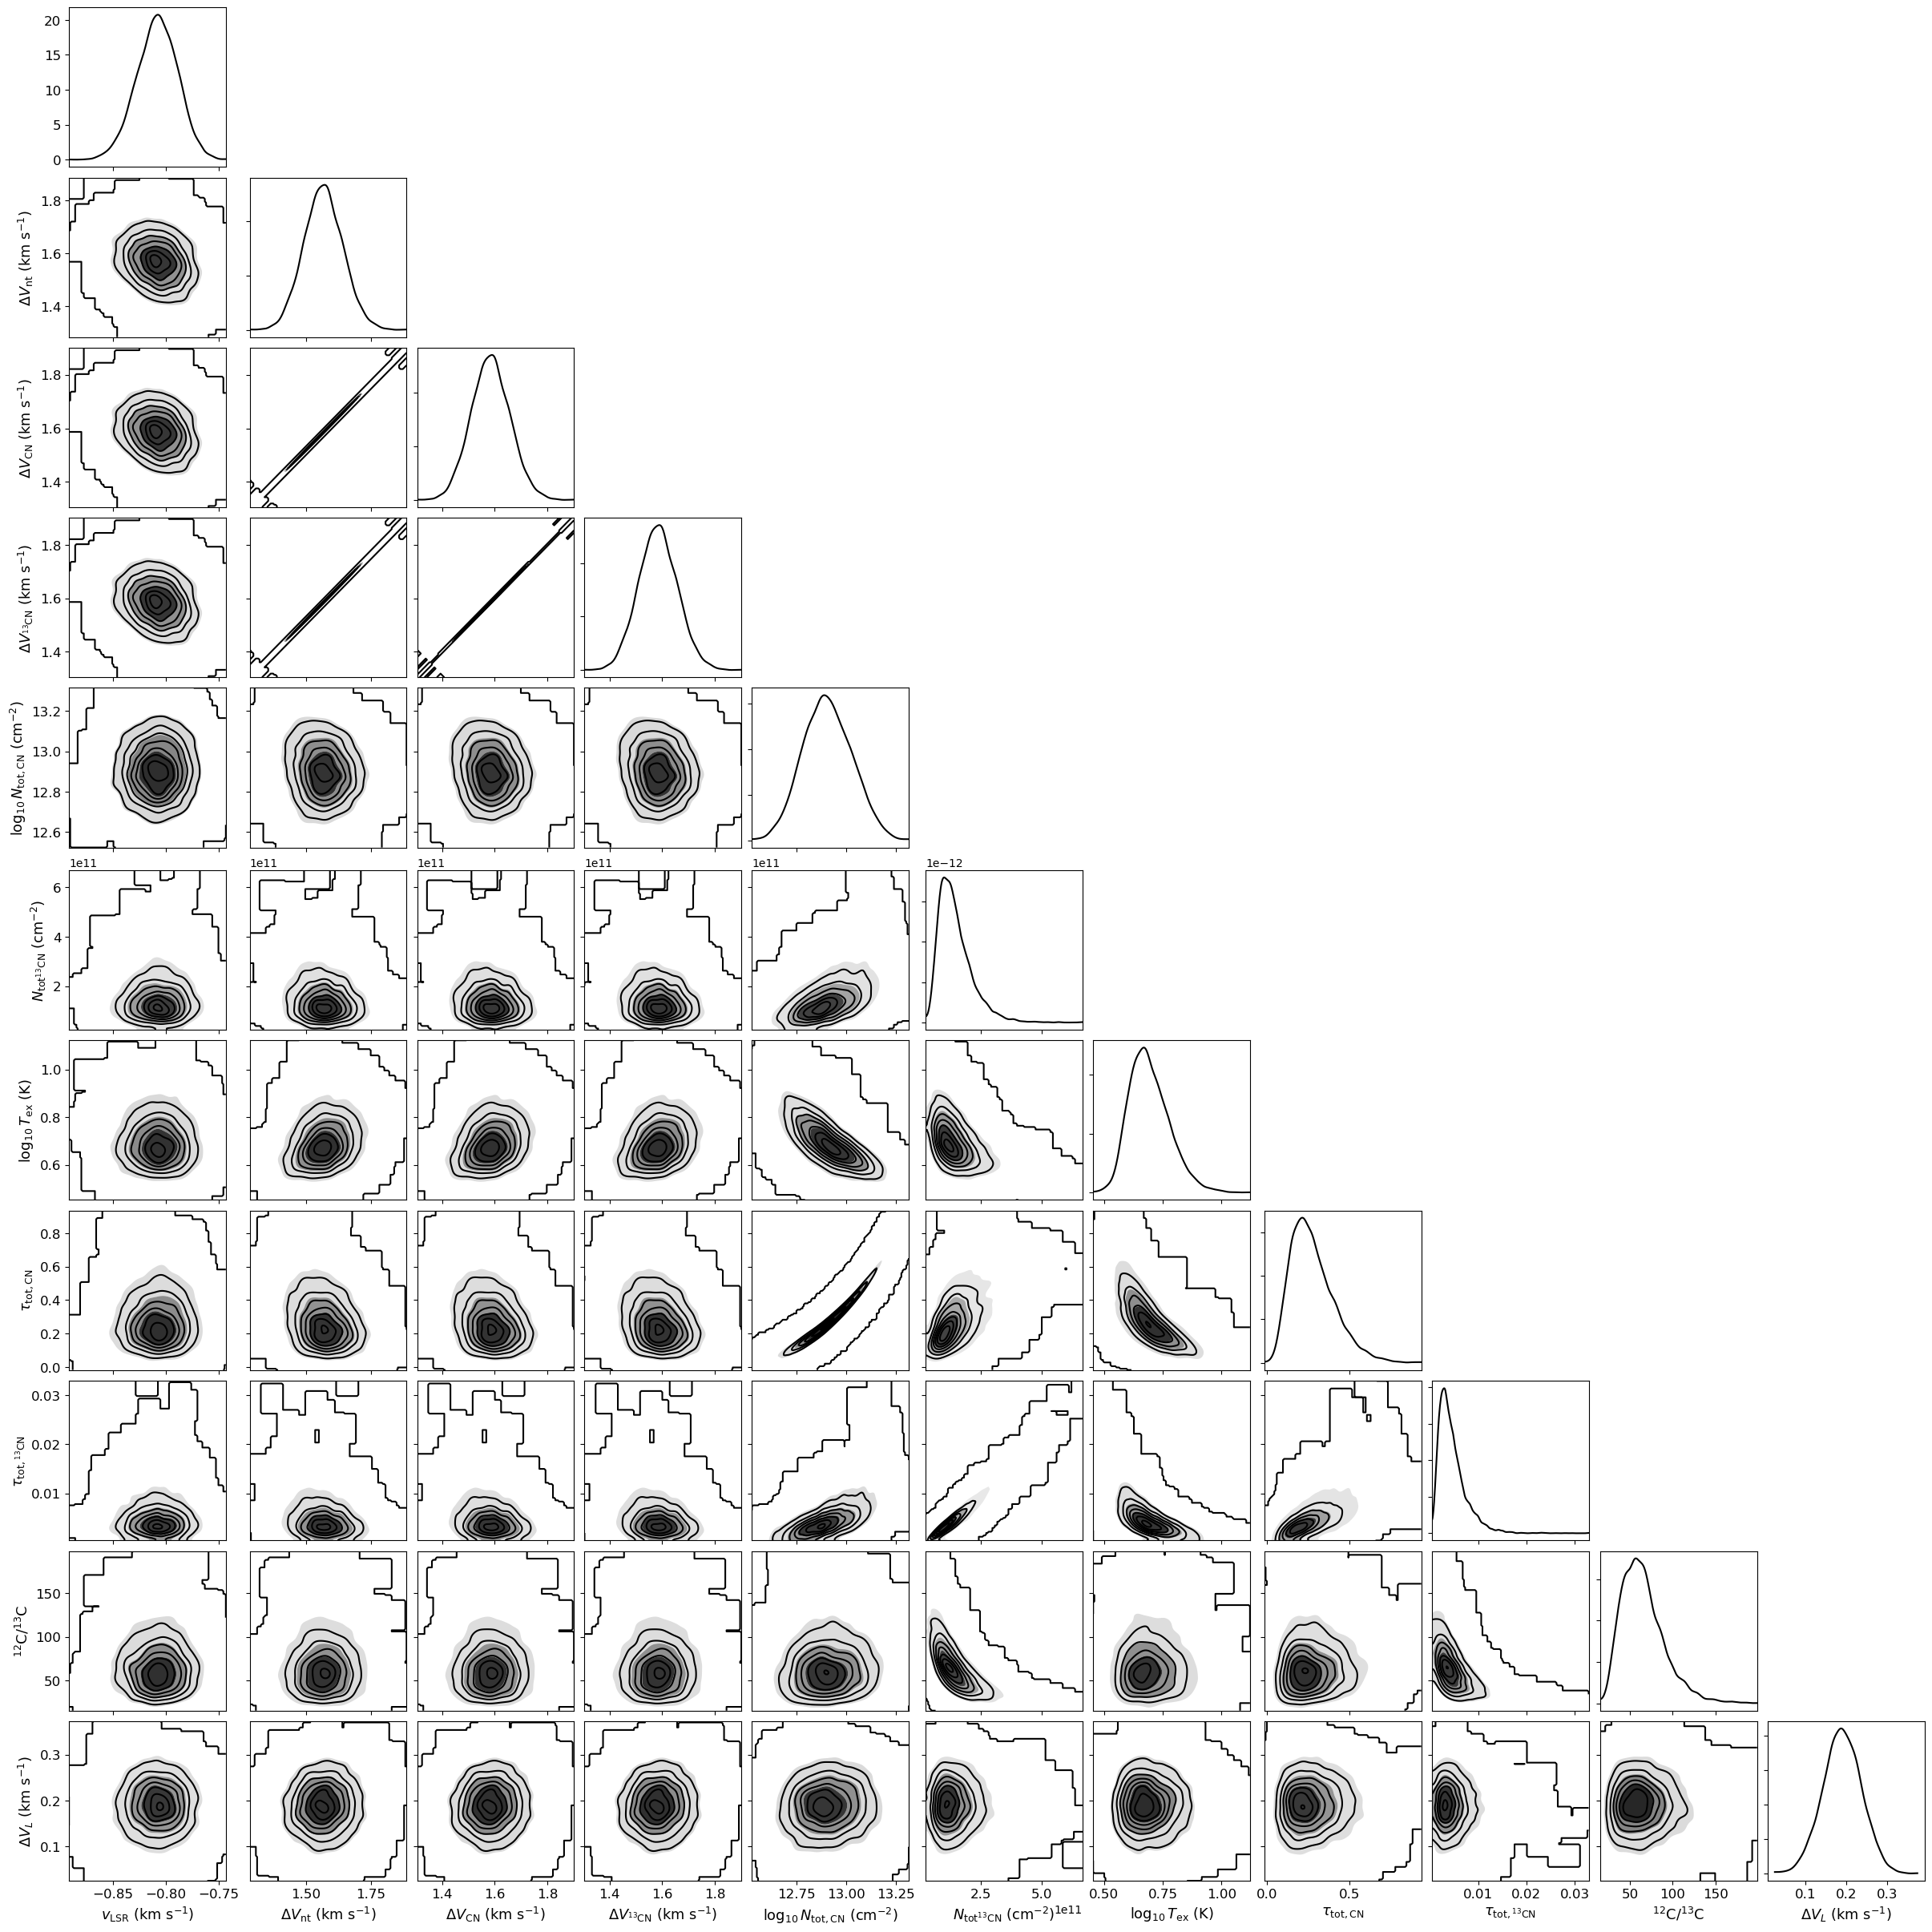

In [58]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics + ["ratio_12C_13C"]
    if not set(model.model.named_vars_to_dims[param]).intersection(set(
        ["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]
    )) and param not in ["fwhm_thermal_12CN", "fwhm_thermal_13CN"]
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

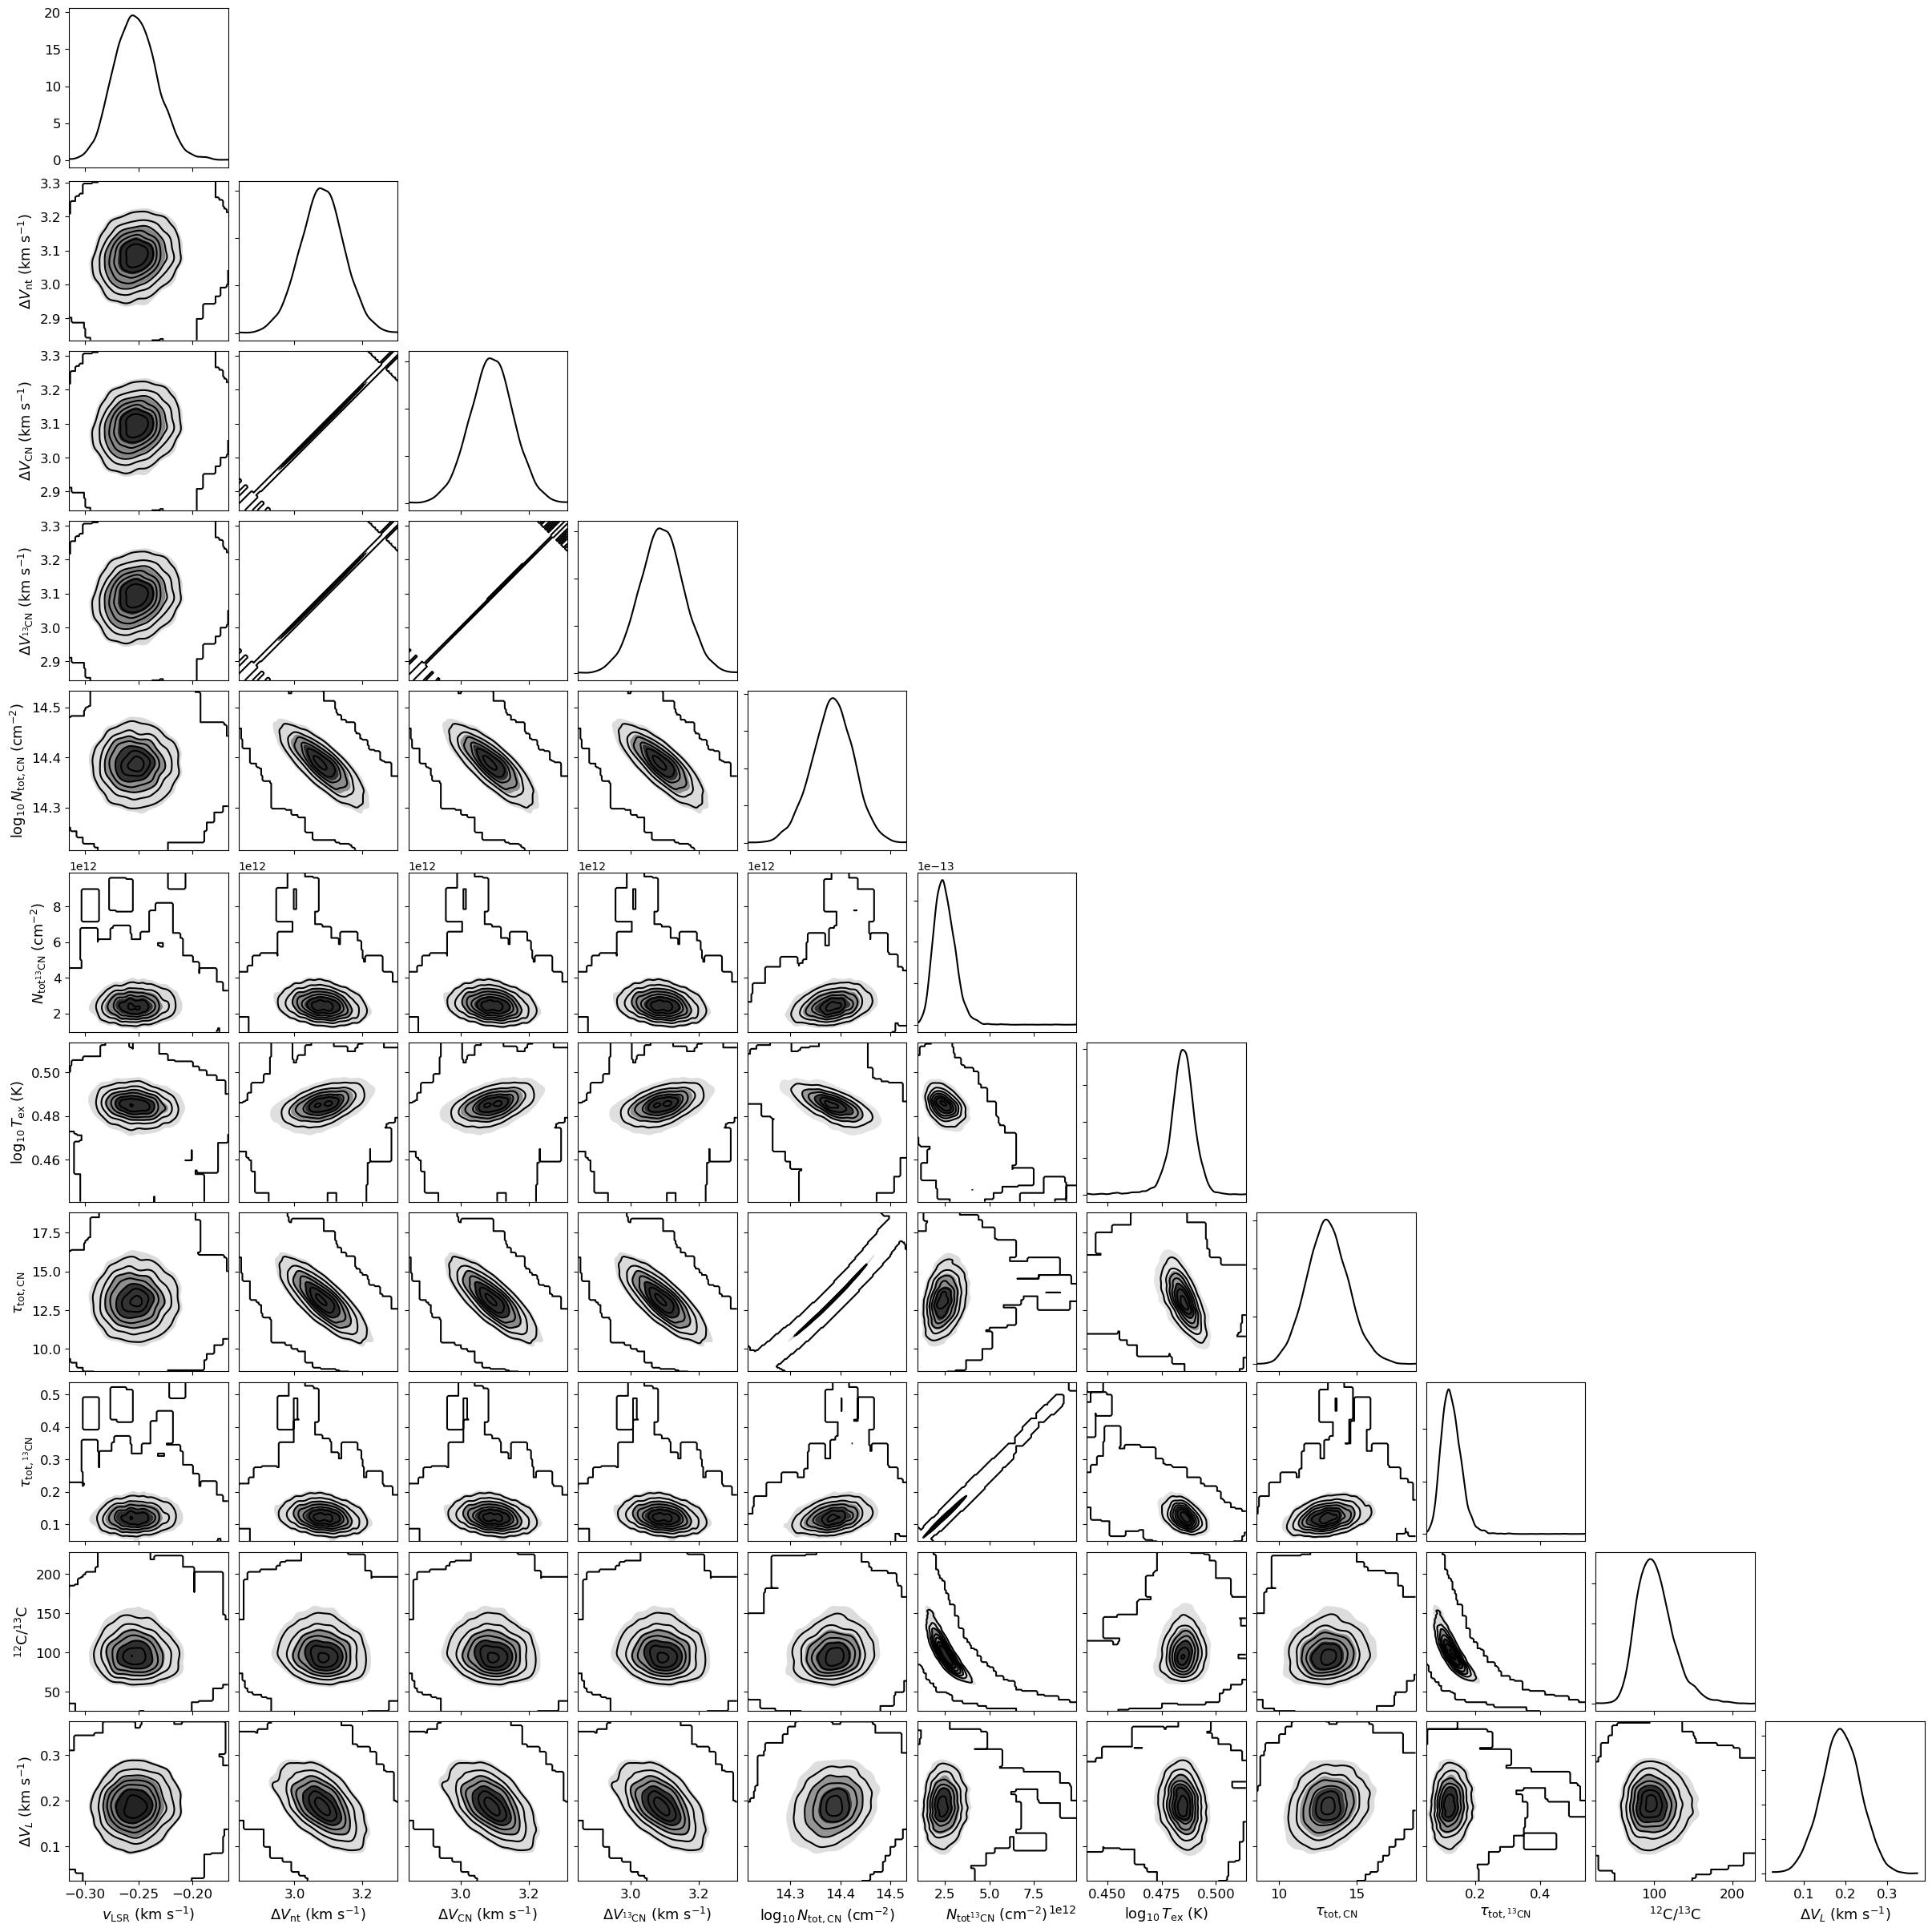

In [59]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

In [60]:
var_names = model.cloud_deterministics + model.baseline_freeRVs + model.hyper_freeRVs + model.hyper_deterministics + ["ratio_12C_13C", "ratio_12C_13C_total"]
point_stats = az.summary(model.trace.solution_0, var_names=var_names, kind='stats', hdi_prob=0.68)
display(point_stats)

mean            sd       hdi_16%  \
velocity[0]              -8.080000e-01  1.900000e-02 -8.250000e-01   
velocity[1]              -2.530000e-01  2.000000e-02 -2.740000e-01   
fwhm_thermal_12CN[0]      2.360000e-01  0.000000e+00  2.360000e-01   
fwhm_thermal_12CN[1]      2.360000e-01  0.000000e+00  2.360000e-01   
fwhm_thermal_13CN[0]      2.320000e-01  0.000000e+00  2.320000e-01   
fwhm_thermal_13CN[1]      2.320000e-01  0.000000e+00  2.320000e-01   
fwhm_nonthermal[0]        1.567000e+00  7.500000e-02  1.488000e+00   
fwhm_nonthermal[1]        3.082000e+00  6.500000e-02  3.017000e+00   
fwhm_12CN[0]              1.585000e+00  7.400000e-02  1.507000e+00   
fwhm_12CN[1]              3.091000e+00  6.400000e-02  3.026000e+00   
fwhm_13CN[0]              1.584000e+00  7.400000e-02  1.506000e+00   
fwhm_13CN[1]              3.090000e+00  6.400000e-02  3.026000e+00   
log10_N_12CN[0]           1.290400e+01  1.220000e-01  1.277700e+01   
log10_N_12CN[1]           1.438400e+01  4.200000e-02  1.434800e+01   
N_13CN[0]                 1.455784e+11  6.921605e+10  6.769610e+10   
N_13CN[1]                 2.511788e+12  6.236147e+11  1.774565e+12   
log10_Tex_ul[0]           6.940000e-01  8.600000e-02  5.920000e-01   
log10_Tex_ul[1]           4.840000e-01  6.000000e-03  4.800000e-01   
Tex_12CN[113123.3687, 0]  4.517000e+00  2.439000e+00  3.488000e+00   
Tex_12CN[113123.3687, 1]  3.088000e+00  3.300000e-02  3.050000e+00   
Tex_12CN[113144.19, 0]    4.560000e+00  2.625000e+00  3.580000e+00   
Tex_12CN[113144.19, 1]    3.084000e+00  3.000000e-02  3.054000e+00   
Tex_12CN[113170.535, 0]   5.282000e+00  3.415000e+00  3.871000e+00   
Tex_12CN[113170.535, 1]   3.062000e+00  2.800000e-02  3.032000e+00   
Tex_12CN[113191.325, 0]   5.287000e+00  1.923000e+00  3.843000e+00   
Tex_12CN[113191.325, 1]   3.058000e+00  2.600000e-02  3.030000e+00   
Tex_12CN[113488.142, 0]   4.619000e+00  2.739000e+00  3.611000e+00   
Tex_12CN[113488.142, 1]   3.031000e+00  2.700000e-02  3.003000e+00   
Tex_12CN[113490.985, 0]   7.429000e+00  2.154400e+01  4.574000e+00   
Tex_12CN[113490.985, 1]   3.084000e+00  1.900000e-02  3.065000e+00   
Tex_12CN[113499.643, 0]   4.366000e+00  1.381000e+00  3.469000e+00   
Tex_12CN[113499.643, 1]   3.025000e+00  2.700000e-02  2.998000e+00   
Tex_12CN[113508.934, 0]   4.737000e+00  1.465000e+00  3.665000e+00   
Tex_12CN[113508.934, 1]   3.028000e+00  2.500000e-02  3.000000e+00   
Tex_12CN[113520.4215, 0]  4.438000e+00  9.940000e-01  3.450000e+00   
Tex_12CN[113520.4215, 1]  3.021000e+00  2.700000e-02  2.993000e+00   
tau_12CN[113123.3687, 0]  4.000000e-03  2.000000e-03  2.000000e-03   
tau_12CN[113123.3687, 1]  1.580000e-01  1.700000e-02  1.420000e-01   
tau_12CN[113144.19, 0]    2.900000e-02  1.300000e-02  1.300000e-02   
tau_12CN[113144.19, 1]    1.296000e+00  1.340000e-01  1.164000e+00   
tau_12CN[113170.535, 0]   2.700000e-02  1.300000e-02  1.200000e-02   
tau_12CN[113170.535, 1]   1.266000e+00  1.320000e-01  1.140000e+00   
tau_12CN[113191.325, 0]   3.500000e-02  1.700000e-02  1.600000e-02   
tau_12CN[113191.325, 1]   1.648000e+00  1.700000e-01  1.480000e+00   
tau_12CN[113488.142, 0]   3.700000e-02  1.700000e-02  1.700000e-02   
tau_12CN[113488.142, 1]   1.655000e+00  1.720000e-01  1.494000e+00   
tau_12CN[113490.985, 0]   8.100000e-02  4.300000e-02  3.000000e-02   
tau_12CN[113490.985, 1]   4.380000e+00  4.470000e-01  3.934000e+00   
tau_12CN[113499.643, 0]   3.000000e-02  1.300000e-02  1.300000e-02   
tau_12CN[113499.643, 1]   1.307000e+00  1.360000e-01  1.178000e+00   
tau_12CN[113508.934, 0]   2.800000e-02  1.300000e-02  1.200000e-02   
tau_12CN[113508.934, 1]   1.280000e+00  1.320000e-01  1.149000e+00   
tau_12CN[113520.4215, 0]  4.000000e-03  2.000000e-03  2.000000e-03   
tau_12CN[113520.4215, 1]  1.600000e-01  1.600000e-02  1.440000e-01   
tau_total_12CN[0]         2.760000e-01  1.320000e-01  1.150000e-01   
tau_total_12CN[1]         1.315000e+01  1.354000e+00  1.186400e+01   
TR_12CN[113123.3687, 0]   2.353000e+00  2.40

## Assumption about 13CN Excitation Temperature
There is no evidence for CTEX in the 13CN data, and we are unable to constrain the excitation temperature of 13CN because we only detect the brightest transitions. Here we relax the 13CN CTEX assumption and instead assume that it suffers from hyperfine anomalies the same as 12CN.

In [61]:
from bayes_cn_hfs.cn_ratio_model import CNRatioModel

# Initialize and define the model
n_clouds = 2 # number of cloud components
baseline_degree = 0 # polynomial baseline degree
model = CNRatioModel(
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [13.50, 0.25], # mean and width of log10 12CN total column density prior (cm-2)
    prior_ratio_12C_13C = [50.0, 25.0], # mean and width of 12C/13C ratio prior
    prior_log10_Tkin = None, # kinetic temperature is fixed
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log10_Tex = [0.6, 0.15], # mean and width of excitation temperature prior (K)
    assume_CTEX_12CN = False, # do not assume CTEX
    prior_LTE_precision = 100.0, # width of LTE precision prior
    assume_CTEX_13CN = True, # assume CTEX for 13CN
    fix_log10_Tkin = 1.5, # kinetic temperature is fixed (K)
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Sampling: [12CN-1, 12CN-2, 13CN, LTE_precision, baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N_12CN_norm, log10_Tex_ul_norm, ratio_12C_13C, velocity_norm, weights_12CN]


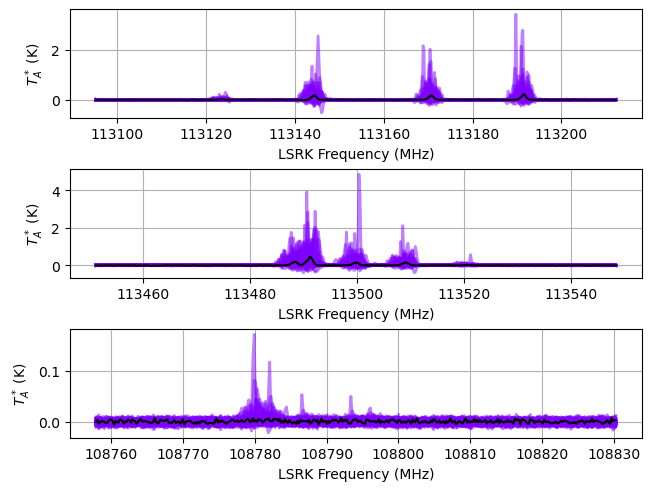

In [62]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [63]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.01, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 5600
Interrupted at 5,599 [5%]: Average Loss = 15,503


Output()

Runtime: 1.15 minutes


Sampling: [12CN-1, 12CN-2, 13CN]


Output()

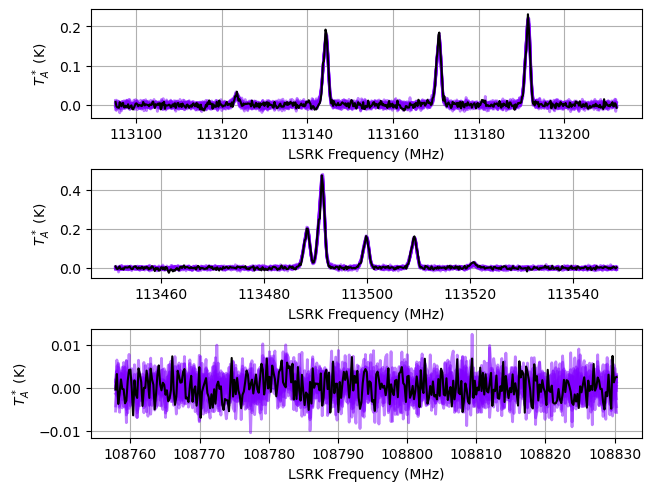

In [64]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [65]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 0.01}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.9}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 5600
Interrupted at 5,599 [5%]: Average Loss = 15,503
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_12CN_norm, ratio_12C_13C, log10_Tex_ul_norm, LTE_precision, weights_12CN]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 3222 seconds.


Adding log-likelihood to trace


Output()

There were 1 divergences in converged chains.
Runtime: 55.52 minutes


In [66]:
model.solve(kl_div_threshold=0.1)

GMM found 2 unique solutions
Solution 0: chains [0, 2, 3, 4, 5, 6]
Solution 1: chains [1, 7]


In [67]:
print("solutions:", model.solutions)

pm.summary(model.trace.solution_0)

solutions: [0, 1]


/opt/conda/envs/bayes_cn_hfs-dev/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean            sd        hdi_3%  \
baseline_12CN-1_norm[0]  -1.810000e-01  4.200000e-02 -2.590000e-01   
baseline_12CN-2_norm[0]  -3.450000e-01  5.000000e-02 -4.370000e-01   
baseline_13CN_norm[0]     8.000000e-03  5.300000e-02 -8.800000e-02   
velocity_norm[0]         -2.690000e-01  6.000000e-03 -2.820000e-01   
velocity_norm[1]         -8.400000e-02  7.000000e-03 -9.600000e-02   
log10_N_12CN_norm[0]     -2.382000e+00  4.890000e-01 -3.295000e+00   
log10_N_12CN_norm[1]      3.536000e+00  1.680000e-01  3.224000e+00   
log10_Tex_ul_norm[0]      6.270000e-01  5.710000e-01 -3.460000e-01   
log10_Tex_ul_norm[1]     -7.710000e-01  4.200000e-02 -8.460000e-01   
fwhm_nonthermal_norm[0]   1.567000e+00  7.500000e-02  1.422000e+00   
fwhm_nonthermal_norm[1]   3.082000e+00  6.500000e-02  2.964000e+00   
fwhm_L_norm               1.890000e-01  4.700000e-02  1.010000e-01   
ratio_12C_13C[0]          6.556300e+01  2.520900e+01  2.604000e+01   
ratio_12C_13C[1]          1.018490e+02  2.366400e+01  6.081000e+01   
LTE_precision[0]          6.000000e-03  4.000000e-03  1.000000e-03   
LTE_precision[1]          0.000000e+00  0.000000e+00  0.000000e+00   
weights_12CN[0, 0 0 1 1]  1.650000e-01  2.000000e-02  1.280000e-01   
weights_12CN[0, 0 0 1 2]  3.250000e-01  3.600000e-02  2.560000e-01   
weights_12CN[0, 1 0 1 1]  4.700000e-02  5.000000e-03  3.800000e-02   
weights_12CN[0, 1 0 1 2]  1.100000e-01  1.200000e-02  9.000000e-02   
weights_12CN[0, 1 0 2 1]  4.600000e-02  5.000000e-03  3.600000e-02   
weights_12CN[0, 1 0 2 2]  9.800000e-02  9.000000e-03  8.200000e-02   
weights_12CN[0, 1 0 2 3]  2.090000e-01  2.500000e-02  1.660000e-01   
weights_12CN[1, 0 0 1 1]  2.210000e-01  1.000000e-03  2.180000e-01   
weights_12CN[1, 0 0 1 2]  4.430000e-01  2.000000e-03  4.390000e-01   
weights_12CN[1, 1 0 1 1]  3.800000e-02  1.000000e-03  3.700000e-02   
weights_12CN[1, 1 0 1 2]  7.500000e-02  1.000000e-03  7.400000e-02   
weights_12CN[1, 1 0 2 1]  3.600000e-02  0.000000e+00  3.600000e-02   
weights_12CN[1, 1 0 2 2]  7.300000e-02  1.000000e-03  7.200000e-02   
weights_12CN[1, 1 0 2 3]  1.140000e-01  1.000000e-03  1.120000e-01   
velocity[0]              -8.080000e-01  1.900000e-02 -8.460000e-01   
velocity[1]              -2.530000e-01  2.000000e-02 -2.880000e-01   
fwhm_thermal_12CN[0]      2.360000e-01  0.000000e+00  2.360000e-01   
fwhm_thermal_12CN[1]      2.360000e-01  0.000000e+00  2.360000e-01   
fwhm_thermal_13CN[0]      2.320000e-01  0.000000e+00  2.320000e-01   
fwhm_thermal_13CN[1]      2.320000e-01  0.000000e+00  2.320000e-01   
fwhm_nonthermal[0]        1.567000e+00  7.500000e-02  1.422000e+00   
fwhm_nonthermal[1]        3.082000e+00  6.500000e-02  2.964000e+00   
fwhm_12CN[0]              1.585000e+00  7.400000e-02  1.441000e+00   
fwhm_12CN[1]              3.091000e+00  6.400000e-02  2.973000e+00   
fwhm_13CN[0]              1.584000e+00  7.400000e-02  1.440000e+00   
fwhm_13CN[1]              3.090000e+00  6.400000e-02  2.973000e+00   
fwhm_L                    1.890000e-01  4.700000e-02  1.010000e-01   
log10_N_12CN[0]           1.290400e+01  1.220000e-01  1.267600e+01   
log10_N_12CN[1]           1.438400e+01  4.200000e-02  1.430600e+01   
N_13CN[0]                 1.455784e+11  6.921605e+10  4.240221e+10   
N_13CN[1]                 2.511788e+12  6.236147e+11  1.520469e+12   
log10_Tex_ul[0]           6.940000e-01  8.600000e-02  5.480000e-01   
log10_Tex_ul[1]           4.840000e-01  6.000000e-03  4.730000e-01   
Tex_12CN[113123.3687, 0]  4.517000e+00  2.439000e+00  3.233000e+00   
Tex_12CN[113123.3687, 1]  3.088000e+00  3.300000e-02  3.028000e+00   
Tex_12CN[113144.19, 0]    4.560000e+00  2.625000e+00  3.352000e+00   
Tex_12CN[113144.19, 1]    3.084000e+00  3.000000e-02  3.027000e+00   
Tex_12CN[113170.535, 0]   5.282000e+00  3.415000e+00  3.547000e+00   
Tex_12CN[113170.535, 1]   3.062000e+00  2.800000e-02  3.014000e+00   
Tex_12CN[113191.325, 0]   5.287000e+00  1.923000e+00  3.570000e+00   
Tex_12CN[113191.325, 1]   3.058000e+00  2.60

In [73]:
pm.summary(model.trace.solution_1)

/opt/conda/envs/bayes_cn_hfs-dev/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean            sd        hdi_3%  \
baseline_12CN-1_norm[0]  -1.870000e-01  4.500000e-02 -2.690000e-01   
baseline_12CN-2_norm[0]  -3.540000e-01  5.000000e-02 -4.440000e-01   
baseline_13CN_norm[0]     9.000000e-03  5.200000e-02 -9.500000e-02   
velocity_norm[0]         -3.520000e-01  7.000000e-03 -3.650000e-01   
velocity_norm[1]          1.900000e-01  1.100000e-02  1.700000e-01   
log10_N_12CN_norm[0]     -8.230000e-01  2.840000e-01 -1.326000e+00   
log10_N_12CN_norm[1]      3.773000e+00  2.320000e-01  3.323000e+00   
log10_Tex_ul_norm[0]      1.298000e+00  5.300000e-01  3.390000e-01   
log10_Tex_ul_norm[1]     -9.470000e-01  5.900000e-02 -1.067000e+00   
fwhm_nonthermal_norm[0]   2.333000e+00  5.000000e-02  2.242000e+00   
fwhm_nonthermal_norm[1]   1.963000e+00  1.200000e-01  1.725000e+00   
fwhm_L_norm               3.070000e-01  4.000000e-02  2.340000e-01   
ratio_12C_13C[0]          7.184200e+01  2.189200e+01  3.831600e+01   
ratio_12C_13C[1]          9.424200e+01  2.967200e+01  3.996300e+01   
LTE_precision[0]          1.000000e-03  2.000000e-03  0.000000e+00   
LTE_precision[1]          0.000000e+00  1.000000e-03  0.000000e+00   
weights_12CN[0, 0 0 1 1]  1.440000e-01  1.400000e-02  1.200000e-01   
weights_12CN[0, 0 0 1 2]  2.970000e-01  2.500000e-02  2.510000e-01   
weights_12CN[0, 1 0 1 1]  6.600000e-02  5.000000e-03  5.600000e-02   
weights_12CN[0, 1 0 1 2]  1.320000e-01  1.000000e-02  1.130000e-01   
weights_12CN[0, 1 0 2 1]  6.100000e-02  5.000000e-03  5.200000e-02   
weights_12CN[0, 1 0 2 2]  1.230000e-01  9.000000e-03  1.070000e-01   
weights_12CN[0, 1 0 2 3]  1.760000e-01  1.000000e-02  1.590000e-01   
weights_12CN[1, 0 0 1 1]  2.290000e-01  1.000000e-03  2.270000e-01   
weights_12CN[1, 0 0 1 2]  4.550000e-01  1.000000e-03  4.530000e-01   
weights_12CN[1, 1 0 1 1]  3.500000e-02  0.000000e+00  3.500000e-02   
weights_12CN[1, 1 0 1 2]  7.000000e-02  1.000000e-03  6.900000e-02   
weights_12CN[1, 1 0 2 1]  3.400000e-02  0.000000e+00  3.400000e-02   
weights_12CN[1, 1 0 2 2]  6.800000e-02  0.000000e+00  6.700000e-02   
weights_12CN[1, 1 0 2 3]  1.090000e-01  1.000000e-03  1.080000e-01   
velocity[0]              -1.056000e+00  2.200000e-02 -1.096000e+00   
velocity[1]               5.690000e-01  3.400000e-02  5.090000e-01   
fwhm_thermal_12CN[0]      2.360000e-01  0.000000e+00  2.360000e-01   
fwhm_thermal_12CN[1]      2.360000e-01  0.000000e+00  2.360000e-01   
fwhm_thermal_13CN[0]      2.320000e-01  0.000000e+00  2.320000e-01   
fwhm_thermal_13CN[1]      2.320000e-01  0.000000e+00  2.320000e-01   
fwhm_nonthermal[0]        2.333000e+00  5.000000e-02  2.242000e+00   
fwhm_nonthermal[1]        1.963000e+00  1.200000e-01  1.725000e+00   
fwhm_12CN[0]              2.345000e+00  4.900000e-02  2.255000e+00   
fwhm_12CN[1]              1.977000e+00  1.190000e-01  1.741000e+00   
fwhm_13CN[0]              2.344000e+00  4.900000e-02  2.254000e+00   
fwhm_13CN[1]              1.977000e+00  1.190000e-01  1.741000e+00   
fwhm_L                    3.070000e-01  4.000000e-02  2.340000e-01   
log10_N_12CN[0]           1.329400e+01  7.100000e-02  1.316900e+01   
log10_N_12CN[1]           1.444300e+01  5.800000e-02  1.433100e+01   
N_13CN[0]                 3.013599e+11  9.894715e+10  1.326038e+11   
N_13CN[1]                 3.350754e+12  1.550744e+12  1.345431e+12   
log10_Tex_ul[0]           7.950000e-01  8.000000e-02  6.510000e-01   
log10_Tex_ul[1]           4.580000e-01  9.000000e-03  4.400000e-01   
Tex_12CN[113123.3687, 0]  7.773000e+00  1.018800e+01  4.783000e+00   
Tex_12CN[113123.3687, 1]  2.899000e+00  2.000000e-02  2.860000e+00   
Tex_12CN[113144.19, 0]    7.073000e+00  1.796000e+00  4.679000e+00   
Tex_12CN[113144.19, 1]    2.908000e+00  1.900000e-02  2.874000e+00   
Tex_12CN[113170.535, 0]   7.708000e+00  9.989000e+00  4.662000e+00   
Tex_12CN[113170.535, 1]   2.890000e+00  1.600000e-02  2.862000e+00   
Tex_12CN[113191.325, 0]   7.045000e+00  1.784000e+00  4.770000e+00   
Tex_12CN[113191.325, 1]   2.899000e+00  1.50

Sampling: [12CN-1, 12CN-2, 13CN]


Output()

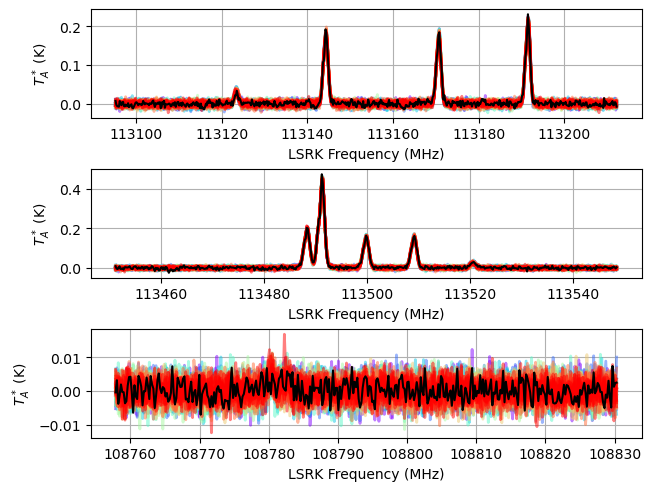

In [68]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [69]:
# 12C/13C ratio over all clouds
for solution in model.solutions:
    model.trace[f"solution_{solution}"]["ratio_12C_13C_total"] = (
        (10.0**model.trace[f"solution_{solution}"]["log10_N_12CN"]).sum(dim="cloud") / 
    model.trace[f"solution_{solution}"]["N_13CN"].sum(dim="cloud")
    )
    

In [70]:
pm.summary(model.trace.solution_0, var_names=["ratio_12C_13C_total"])

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
ratio_12C_13C_total  98.85  21.158  63.583  140.523      0.301    0.215   

                     ess_bulk  ess_tail  r_hat  
ratio_12C_13C_total    4964.0    4081.0    1.0

In [72]:
pm.summary(model.trace.solution_1, var_names=["ratio_12C_13C_total"])

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
ratio_12C_13C_total  90.823  25.847  45.223  143.349      0.656    0.464   

                     ess_bulk  ess_tail  r_hat  
ratio_12C_13C_total    1472.0     991.0    1.0

In [71]:
import pickle
with open("/staging/twenger2/wb89_380_trace_noCTEX.pkl", "wb") as f:
    pickle.dump(model.trace, f)